<a id='top'></a>
<center><img src="../images/iteso_logo.png" style="width:180px;height:180px; vertical- align:middle;" align="middle"></center>
  
<h1><center><b>INSTITUTO TECNOLÓGICO Y DE ESTUDIOS SUPERIORES DE OCCIDENTE</b></center></h1>
<h2><center><b>Maestría en Ciencia de Datos <br><br> Tesis: Atenuación de efectos acústicos en una Señal de Audio</b></center></h2>
<h3><center><b>
               Ing. Adrian Ramos Perez</b></center></h3>

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/AdrianRamosDS/Thesis/blob/main/Tesis_ARP)

<a href="https://colab.research.google.com/github/AdrianRamosDS/Thesis/blob/main/Tesis_ARP_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***

Tabla de Contenido <a id='contents'></a>
-------
- [1. Extracción de los Datos (Data Ingestion and Versioning Step)](#dataextract)
    - [1.1 Señales de Audio](#audiosignals)
    - [1.2 Respuesta al Impulso](#ir)
    - [1.4 Convolución](#conv)
    - [1.5 Dataset Splitting](#split)
- [2. Exploratory Data Analysis (Data Validation Step)](#eda)
    - [2.1 Medidas de Tendencia Central y Dispersión](#stats)
    - [2.2 Verificación de la Estacionariedad e Intervalos de Confianza](#stationary)
- [3. Generación de los Vectores de Características (Preprocessing Step)](#features)
    - [Verificando la Correlación](#corr)
- [4. Modelo y Experimentación (Model Training Step)](#models)
    - [Entrenamiento](#training)
    - [Tuneo Hiperparámetros con GridSearchCV](#tunning) 
- [6. Evaluación y Métricas de Evaluación (Model Analysis)](#metrics)
    - [R2](#r2)
    - [MSE](#mse)
- [7. Conclusiones](#conclusions)
- [8. Referencias](#ref)

In [2]:
#%conda install -c conda-forge scienceplots
#%conda install -c conda-forge mamba
#!mamba install -c conda-forge pandas=1.5.3
#%pip install mlflow
#%pip install tensorflow-addons
#%pip install plotly
#%pip install catboost
#%pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Para obtener más de una salida por cada output de celda de Jupyter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import mlflow
mlflow.__version__

'2.1.1'

In [4]:
# Imports for working with arrays and dataframes:
import numpy as np
import pandas as pd
from pandas import MultiIndex, Int16Dtype # to remove xgboost api warning about compatibility

# Imports for working with audio files:
import soundfile as sf
import librosa as lb
import librosa.display
from IPython.display import Audio

# Imports for visualization:
import plotly.express as px
import matplotlib
#matplotlib.rcParams['text.usetex'] = True
#matplotlib.get_cachedir()
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import scienceplots #plt.style.use('science')

In [5]:
from functools import wraps
import time

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

# 1. Extracción de los Datos <a id='dataextract'></a>
---

## 1.1 Audio signals loading from .wav files: <a id='audiosignals'></a>

In [6]:
sr = 16000
SAMPLING_RATE = 16000

In [7]:
PATH_TRAIN = '../data/train/'
PATH_TEST = '../data/test/'

In [8]:
samples, sr = lb.load(f'{PATH_TRAIN}ADS_train_audio_22kHz.wav', sr=sr, mono=True,offset=0.0,duration=None)
# Duración en segundos:
duration = len(samples)/sr
# Escuchar el audio:
Audio(f'{PATH_TRAIN}ADS_train_audio_22kHz.wav')
duration
print('Sampling rate: '+ str(sr) + ' Hz')
print('Duration:      '+ str(duration) + ' seconds')
print('No. of Samples: ', len(samples))

2.043375

Sampling rate: 16000 Hz
Duration:      2.043375 seconds
No. of Samples:  32694


Text(0.5, 1.0, '$ \t{ADS Speech Signal (original)} sr = 16000 Hz $')

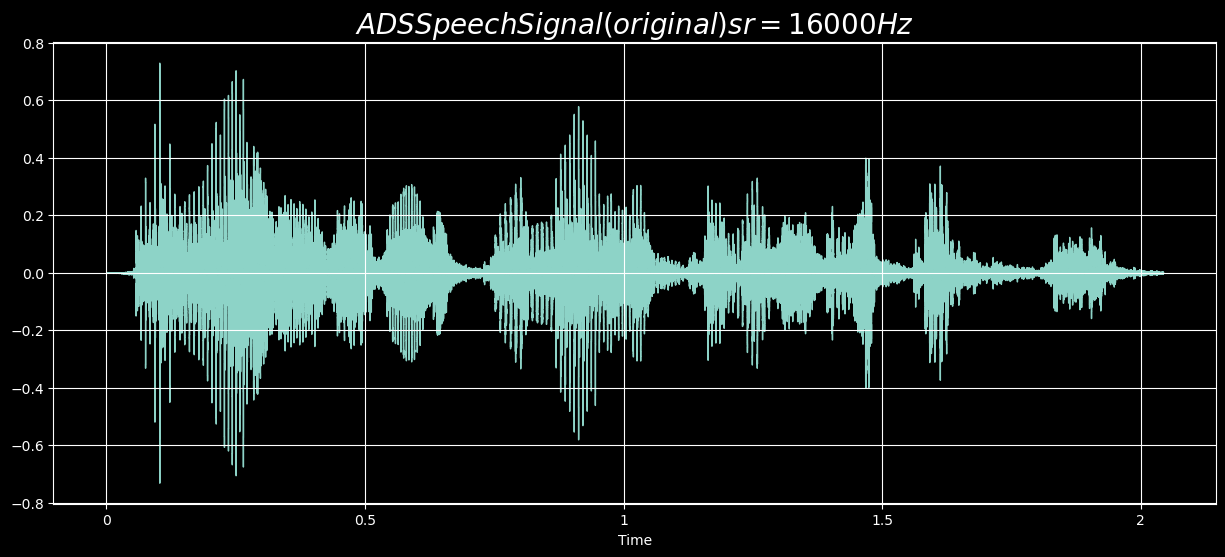

In [9]:

fig = plt.figure(figsize=(15,6))
plt.title(f'$ \t{{ADS Speech Signal (original)}} sr = {sr} Hz $', fontsize=20)
plt.grid(True)
lb.display.waveshow(y=samples,sr=sr)
plt.show()
fig.savefig(f'../figures/Original_signal_sr={sr}')

## 1.2 Impulse Responses: <a id='ir'></a>

#### **22.050 kHz sampled Impulse Response:**

In [10]:
# Cargar respuesta al impulso:
ir_22k_samples, ir_22k_sr= lb.load(f'{PATH_TRAIN}ir_golpe22_short.wav', sr=None, mono=True,offset=0.0,duration=None)
ir_22k_duration = len(ir_22k_samples)/ir_22k_sr
print('Sampling rate: '+ str(ir_22k_sr) + ' Hz')
print('Duration:      '+ str(ir_22k_duration) + ' seconds')
print('No. of Samples:', len(ir_22k_samples))

Sampling rate: 22050 Hz
Duration:      0.16072562358276643 seconds
No. of Samples: 3544


Text(0.5, 1.0, 'Impulse Response sr = 22050')

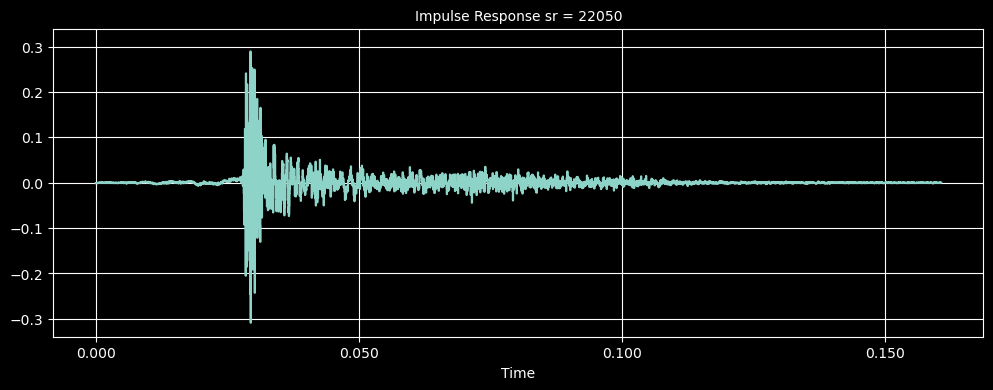

In [11]:
fig = plt.figure(figsize=(12,4))
plt.title(f'Impulse Response sr = {ir_22k_sr}', fontsize=10)
plt.grid()
lb.display.waveshow(y=ir_22k_samples,sr=ir_22k_sr)
plt.show()
fig.savefig(f'../figures/Impulse_Response_sr={ir_22k_sr}')

#### **16 kHz sampled Impulse Response:**

samples from 7000 to 9500

In [12]:
ir_16k_samples, ir_16k_sr = lb.load(f'{PATH_TRAIN}ir_golpe16kHz.wav', sr=None, mono=True,offset=0.0,duration=None)
ir_duration = len(ir_16k_samples)/ir_16k_sr
print('Sampling rate: '+ str(ir_16k_sr) + ' Hz')
print('Duration:      '+ str(ir_duration) + ' seconds')
print('No. of Samples:', len(ir_16k_samples))

Sampling rate: 16000 Hz
Duration:      0.9573125 seconds
No. of Samples: 15317


Text(0.5, 1.0, 'Impulse Response: samplig rate = 16000 Hz')

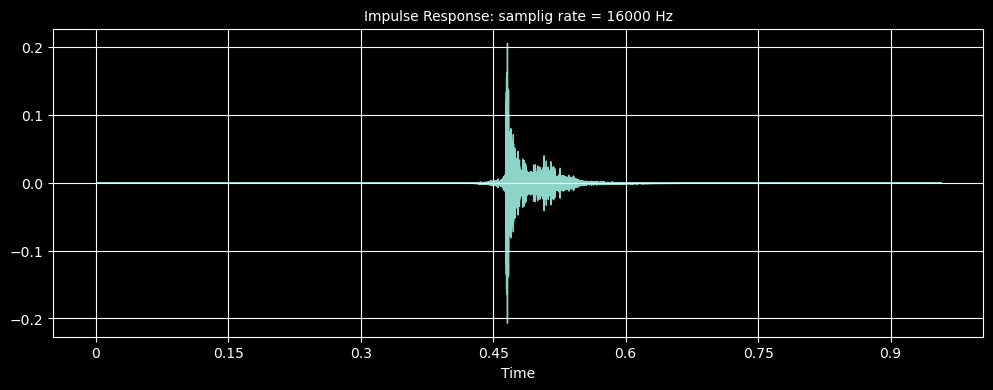

In [13]:
fig = plt.figure(figsize=(12,4))
plt.title(f'Impulse Response: samplig rate = {ir_16k_sr} Hz', fontsize=10)
plt.grid()
lb.display.waveshow(y=ir_16k_samples, sr=ir_16k_sr)
plt.show()
fig.savefig(f'../figures/Impulse_Response_sr={ir_16k_sr}Hz')

Se eliminan fragmentos en cero de la respuesta al impulso:

Duration:      0.15625 seconds
No. of Samples: 2500


Text(0.5, 1.0, 'Impulse Response: samplig rate = 16000 Hz')

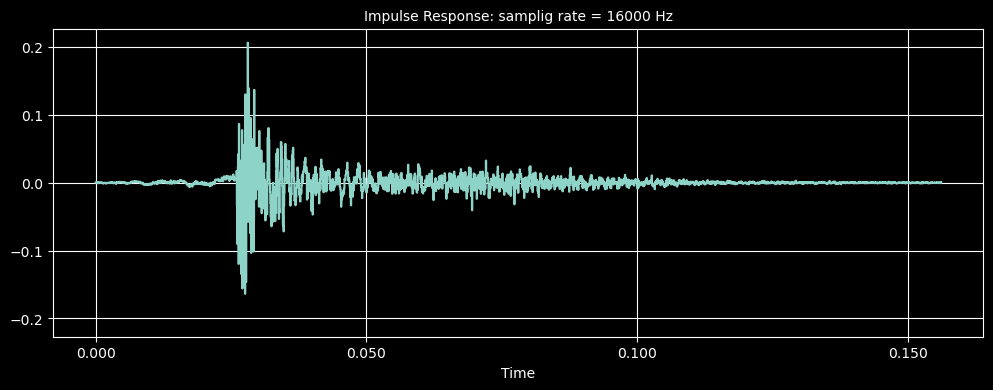

In [14]:
ir_16k_samples = ir_16k_samples[7000:9500]
ir_duration = len(ir_16k_samples)/ir_16k_sr
print('Duration:      '+ str(ir_duration) + ' seconds')
print('No. of Samples:', len(ir_16k_samples))

fig = plt.figure(figsize=(12,4))
plt.title(f'Impulse Response: samplig rate = {ir_16k_sr} Hz', fontsize=10)
plt.grid()
lb.display.waveshow(y=ir_16k_samples, sr=ir_16k_sr)
plt.show()
fig.savefig(f'../figures/Impulse_Response_sr={ir_16k_sr}Hz')

### Loading different speech Audio Signals:

In [16]:
import os

root = f'{PATH_TRAIN}16k/English/'
@timeit
def make_dataset(path):
        
    files_list = os.listdir(path) # Get the list of files present in the directory
    n_files = len(files_list)     # Get the number of files in path directory
    signals = []        # Initialize signals numpy array in 0
    signals_len_map = np.arange(0)
    signals_arr_len = 0
    for i in range(n_files):
        
        signal_path = os.path.join(path, files_list[i])  
        signal, sr = lb.load(signal_path, sr=None, mono=True, offset=0.0, duration=None)
        
        signals.append(signal)
        signals_len_map = np.append(signals_len_map, len(signal)) # Map to track lenght of each signal
        signals_arr_len += len(signal)     # Lenght of the entire concatenated resulting signal
    return signals, n_files, signals_len_map, signals_arr_len

signals, n_signals, signals_len_map, signals_arr_len = make_dataset(root)
#signals.shape()
print(f'Number of signals in the array:{n_signals} \nLength of each signal:{signals_len_map} \nLength of concatenated signals array: {signals_arr_len}')

# Plot all individual signals:
# for i in range(n_signals):
#     fig = plt.figure(figsize=(12,1))
#     lb.display.waveshow(y = signals[i], sr = sr)
#     plt.grid(True) 

Function make_dataset Took 0.0062 seconds
Number of signals in the array:26 
Length of each signal:[16051 13866 16576 18945 13264 19511 22102 27735 26290 17911 16282 15498
 19329 27618 17649 18619 17723 23644 20471 24708 24750 16798 17322 28795
 15992 18260] 
Length of concatenated signals array: 515709


### 1.3 Convolution between train signals and impulse response <a id='conv'></a>

/tmp/ipykernel_1455/2724704370.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,1))


[16051. 13866. 16576. 18945. 13264. 19511. 22102. 27735. 26290. 17911.
 16282. 15498. 19329. 27618. 17649. 18619. 17723. 23644. 20471. 24708.
 24750. 16798. 17322. 28795. 15992. 18260.]


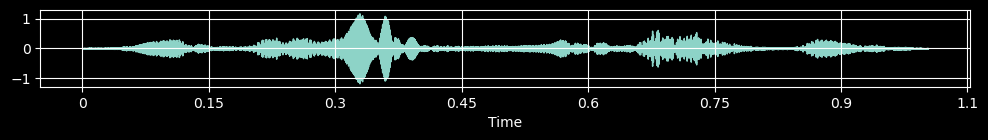

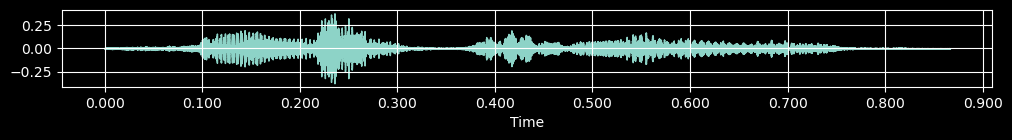

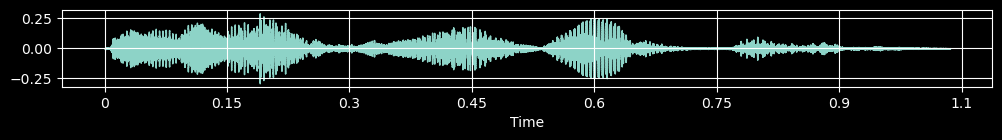

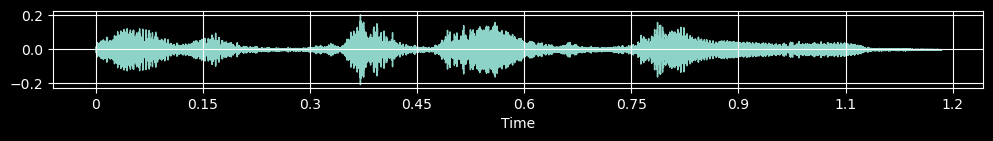

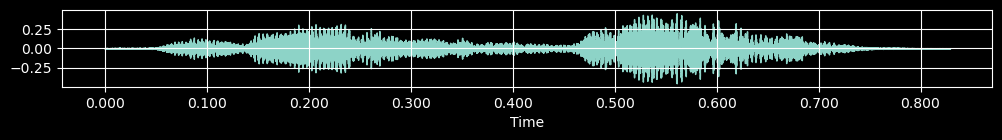

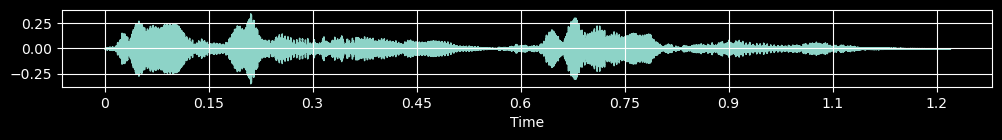

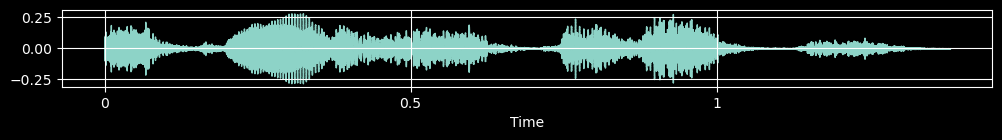

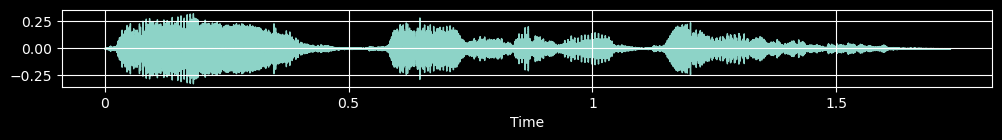

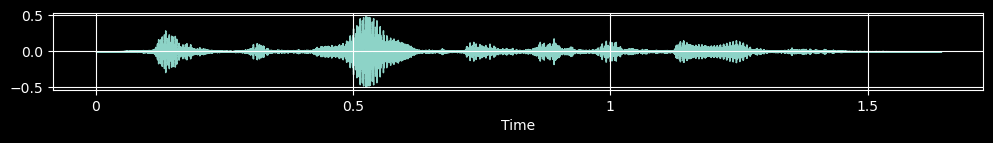

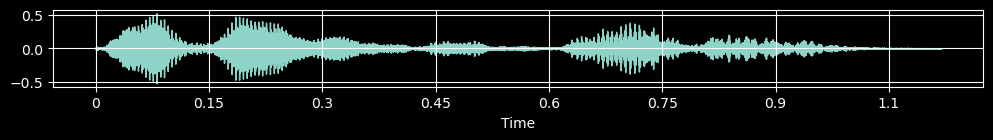

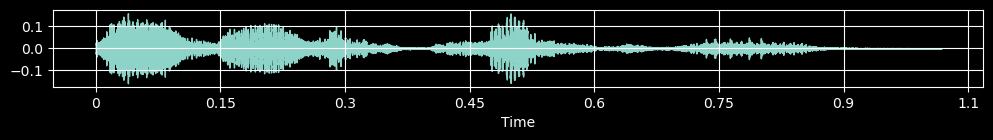

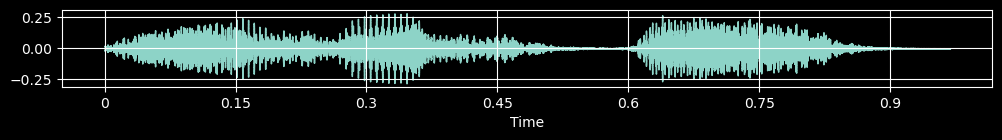

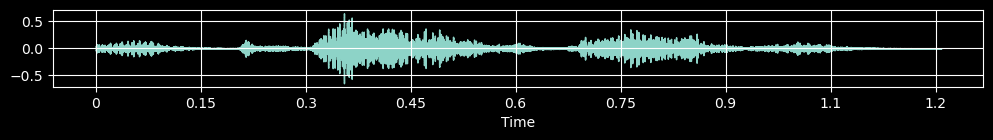

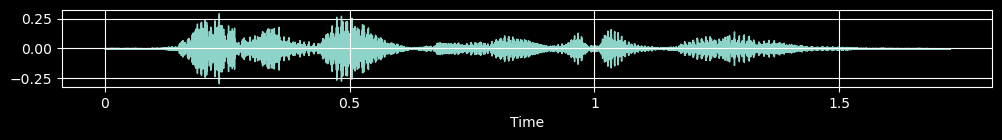

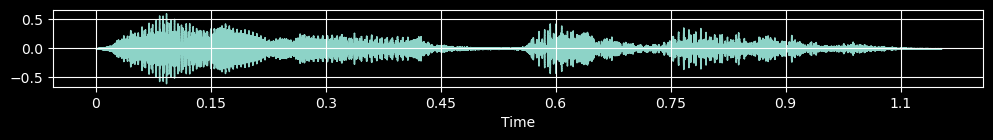

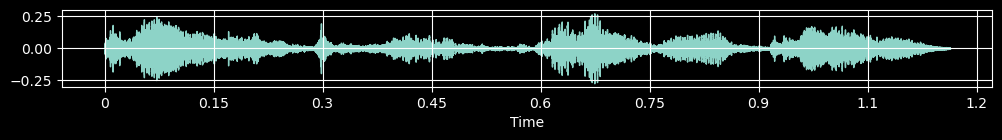

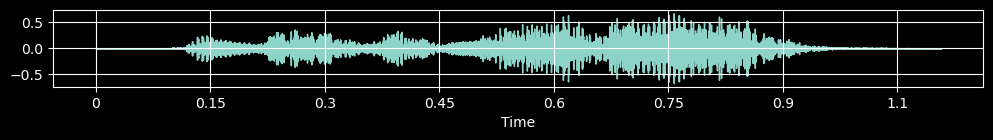

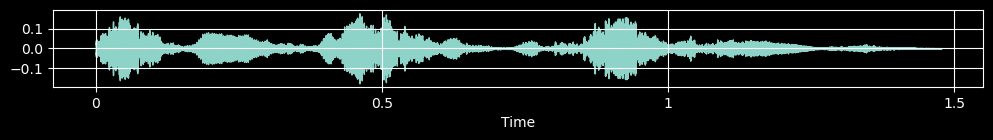

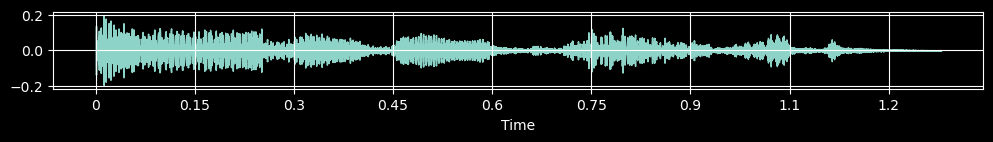

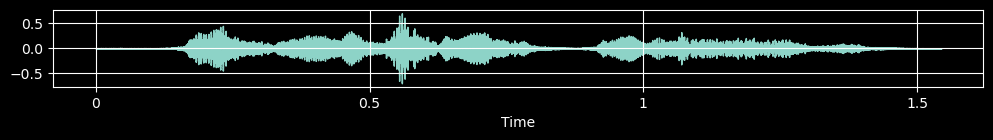

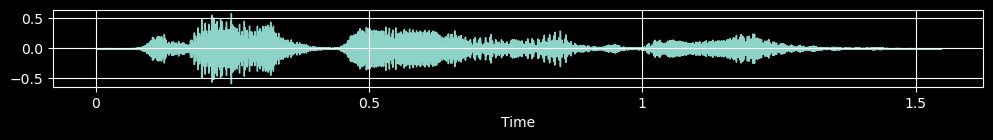

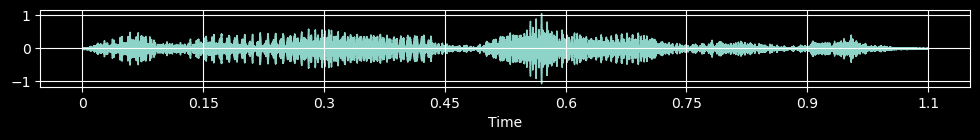

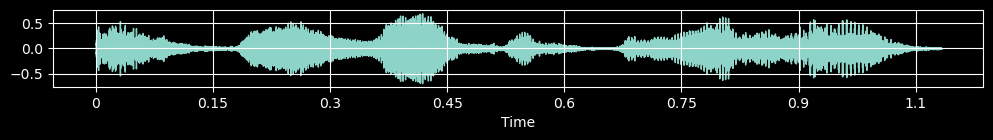

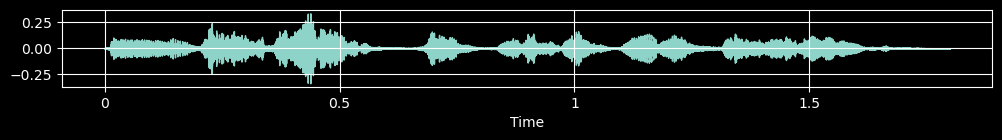

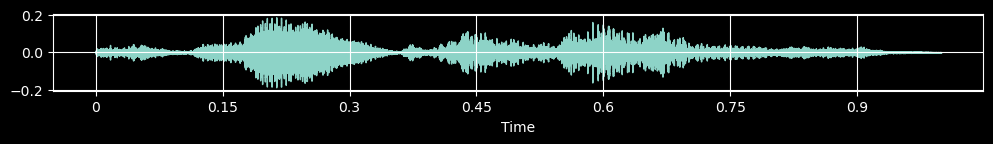

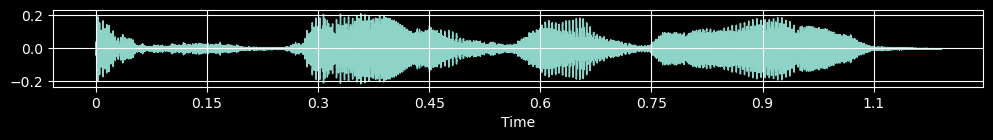

In [17]:
conv_signals = []
conv_signals_arr_len = 0
conv_signals_map = []
for n in range(n_signals):
    convolution = np.convolve(np.array(signals[n]), ir_16k_samples, mode='same')
    #print(f'{convolution}{type(convolution)}')
    conv_signals.append(convolution)
    #print(conv_signals[n])
    conv_signals_map = np.append(conv_signals_map, len(convolution))
    conv_signals_arr_len += len(convolution)
    
    fig = plt.figure(figsize=(12,1))
    lb.display.waveshow(y = conv_signals[n], sr = sr)
    plt.grid(True) 
print(conv_signals_map)

Medimos el largo total de todas las señales concatenadas:

In [18]:
signals_length = 0
conv_signals_length = 0
for n in range(n_signals):
    signals_length += len(signals[n]) 
    conv_signals_length += len(conv_signals[n]) 
    
print(f'Lenght of all signals concatenated: {signals_length}')
print(f'Lenght of all convolved signals concatenated: {conv_signals_length}')

Lenght of all signals concatenated: 515709
Lenght of all convolved signals concatenated: 515709


In [19]:
signals_arr = np.arange(0)
conv_signals_arr = np.arange(0)
for n in range(n_signals):
    signals_arr = np.append(signals_arr, signals[n])
    conv_signals_arr = np.append(conv_signals_arr, conv_signals[n])
len(conv_signals_arr)

515709

Visualizamos ambos vectores:

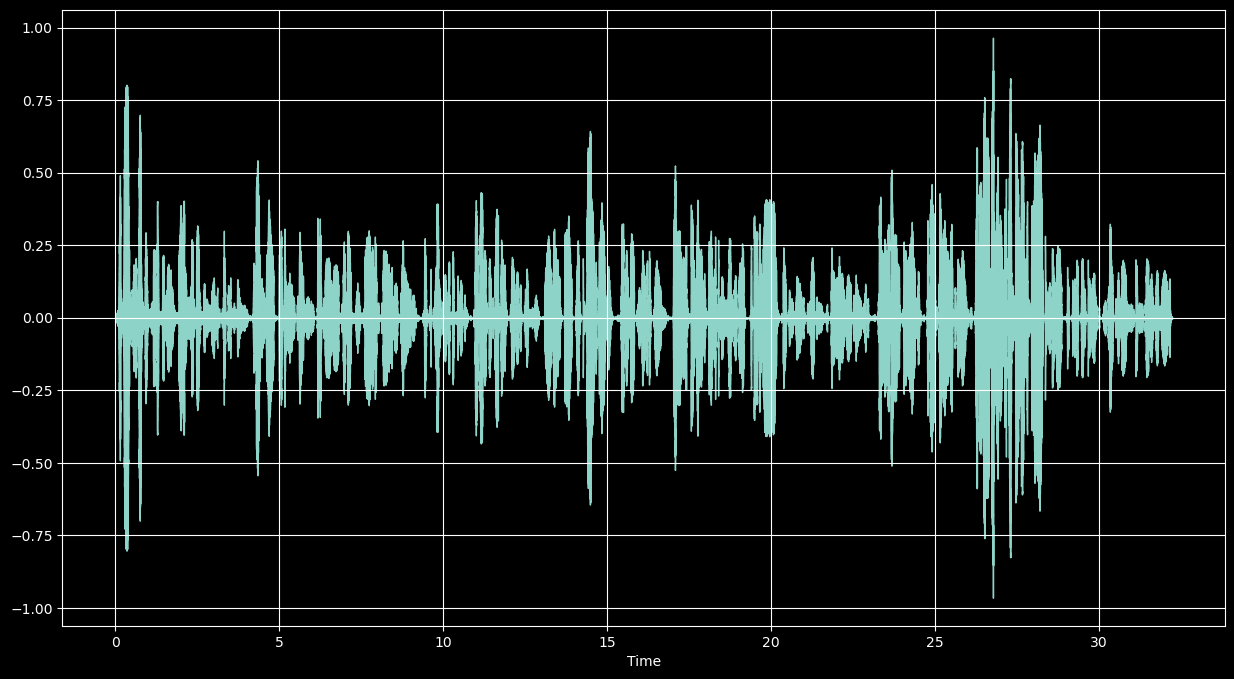

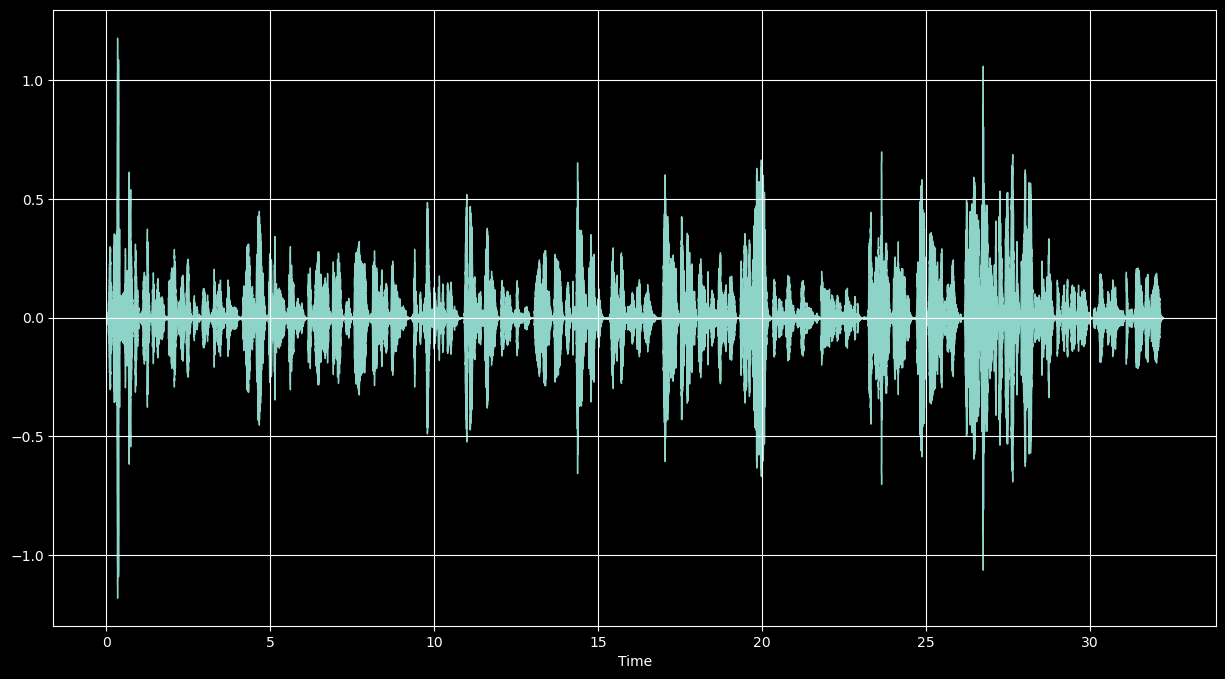

In [34]:
fig = plt.figure(figsize=(15,8))
lb.display.waveshow(y = signals_arr, sr = sr)
plt.grid(True) 

# Escuchar audios:
Audio(f'{PATH_TRAIN}all_signals_english_sr{sr}Hz.wav')

fig = plt.figure(figsize=(15,8))
lb.display.waveshow(y = conv_signals_arr, sr = sr)
plt.grid(True) 

Audio(f'{PATH_TRAIN}all_signals_convolved_english_sr{sr}Hz.wav')

Exportamos a audio como una sola señal:

In [21]:
#conv_signal.astype(np.int16).tofile(f'{path_train}conv_signal.wav')

sf.write(f'{PATH_TRAIN}all_signals_english_sr{sr}Hz.wav', signals_arr, sr, subtype=None)
sf.write(f'{PATH_TRAIN}all_signals_convolved_english_sr{sr}Hz.wav',conv_signals_arr, sr, subtype=None)

Graficamos señal convolucionada:

Text(0.5, 1.0, 'Convolved signal (Impulse Response * Original Speech Signal)')

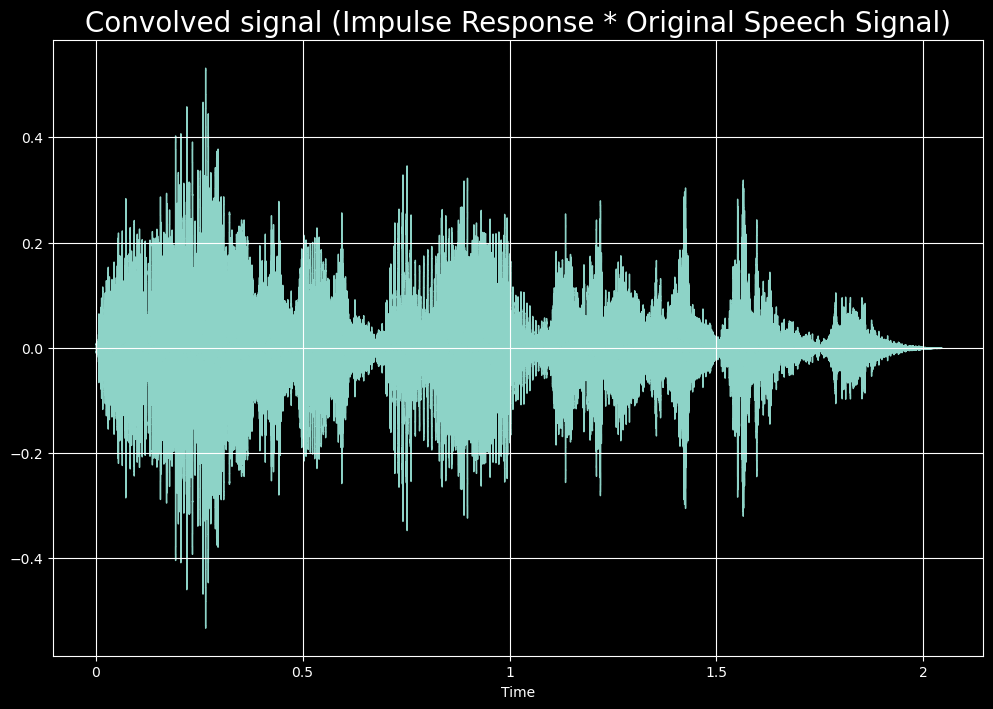

In [23]:
# Convolución de numpy:
conv_signal = np.convolve(samples, ir_16k_samples, mode='same')
# Plot the resulting singal:
fig = plt.figure(figsize=(12,8))
plt.title('Convolved signal (Impulse Response * Original Speech Signal)',fontsize=20)
plt.grid()
lb.display.waveshow(y=conv_signal,sr=sr)
plt.show()
fig.savefig(f'../figures/Convolved_signal')
conv_signal.astype(np.int16).tofile(f'{PATH_TRAIN}conv_signal.wav')
sf.write(f'{PATH_TRAIN}convolved_signal.wav',conv_signal, sr, subtype=None)

---

# 2. Exploratory Data Analysis <a id='eda'></a>
---

# 3. Features Selection <a id='features'></a>
---

### 3.1 Delayed Signal (Lags) Matrix generation
***
Input matrix for the neural network is generated by laggind the convolved audio signal n number of lags, resulting in a matrix of n columns and m equal to the length of the signal(s):

In [45]:
n_lag = 957
n_lag_arr = np.arange(n_lag-450, n_lag+451, 50)
n_lag_arr

array([ 507,  557,  607,  657,  707,  757,  807,  857,  907,  957, 1007,
       1057, 1107, 1157, 1207, 1257, 1307, 1357, 1407])

In [46]:
@timeit
def lag_matrix_gen(signal, n_lag):
    
    # Matrix of dimmensions: (signal-n_lag rows x n_lag columns )    
    lag_matrix = np.zeros((len(signal)-n_lag, n_lag))   
    for i in range(n_lag):
             lag_matrix[:,i] = signal[i : len(signal) - n_lag + i]
    
    return lag_matrix

In [47]:
# ejercicio con vector de 1000
a = np.arange(1001)
b = np.arange(1001,2001)
lag_matrix_gen(a,10)

Function lag_matrix_gen Took 0.0006 seconds


array([[  0.,   1.,   2., ...,   7.,   8.,   9.],
       [  1.,   2.,   3., ...,   8.,   9.,  10.],
       [  2.,   3.,   4., ...,   9.,  10.,  11.],
       ...,
       [988., 989., 990., ..., 995., 996., 997.],
       [989., 990., 991., ..., 996., 997., 998.],
       [990., 991., 992., ..., 997., 998., 999.]])

In [48]:
@timeit
def concat_lag_matrix(signals, conv_signals, n_lag):
    
    n_signals = len(signals)
    print(f'No. of signals: {n_signals}')
    
    lag_matrix = np.zeros((0, n_lag))
    y = np.zeros((0,))
    for n in range(n_signals):
        # X
        temp = lag_matrix_gen(conv_signals[n], n_lag)
        lag_matrix = np.vstack((lag_matrix, temp))
        # Y
        y = np.hstack((y, signals[n][n_lag-1:-1]))

    return lag_matrix, y

In [49]:

d = [[],[]]
d[0] = a
d[1] = b

tst_x, tst_y = concat_lag_matrix(d,d, 8)
tst_x = pd.DataFrame(tst_x)
tst_y = pd.Series(tst_y)
tst_x['Y'] = tst_y
tst_x


No. of signals: 2
Function lag_matrix_gen Took 0.0007 seconds
Function lag_matrix_gen Took 0.0001 seconds
Function concat_lag_matrix Took 0.0010 seconds


0       1       2       3       4       5       6       7       Y
0        0.0     1.0     2.0     3.0     4.0     5.0     6.0     7.0     7.0
1        1.0     2.0     3.0     4.0     5.0     6.0     7.0     8.0     8.0
2        2.0     3.0     4.0     5.0     6.0     7.0     8.0     9.0     9.0
3        3.0     4.0     5.0     6.0     7.0     8.0     9.0    10.0    10.0
4        4.0     5.0     6.0     7.0     8.0     9.0    10.0    11.0    11.0
...      ...     ...     ...     ...     ...     ...     ...     ...     ...
1980  1988.0  1989.0  1990.0  1991.0  1992.0  1993.0  1994.0  1995.0  1995.0
1981  1989.0  1990.0  1991.0  1992.0  1993.0  1994.0  1995.0  1996.0  1996.0
1982  1990.0  1991.0  1992.0  1993.0  1994.0  1995.0  1996.0  1997.0  1997.0
1983  1991.0  1992.0  1993.0  1994.0  1995.0  1996.0  1997.0  1998.0  1998.0
1984  1992.0  1993.0  1994.0  1995.0  1996.0  1997.0  1998.0  1999.0  1999.0

[1985 rows x 9 columns]

Longitud total de todas las señales juntas - número de rezagos x número de señales: <br>
519,213 - 5*26 = 519,083

In [50]:

signals[n].shape


(18260,)

In [74]:
x1 = [conv_signals[19]]
x1_2 = [conv_signals[3]]
x1_3 = [conv_signals[5]]
x2 = [conv_signals[0], conv_signals[2]]
x3 = [conv_signals[0], conv_signals[3], conv_signals[5]]
x4 = [conv_signals[0], conv_signals[2], conv_signals[3], conv_signals[5]]
x5 = [conv_signals[0], conv_signals[2], conv_signals[3], conv_signals[5], conv_signals[6]]
print(len(x5[0])+len(x5[1])+len(x5[2])+len(x5[3])+len(x5[4]))

y1 = [signals[19]]
y1_2 = [signals[3]]
y1_3 = [signals[5]]
y2 = [signals[0], signals[2]]
y3 = [signals[0], signals[3], signals[5]]
y4 = [signals[0], signals[2], signals[3], signals[5]]
y5 = [signals[0], signals[2], signals[3], signals[5], signals[6]]
print(len(y5[0])+len(y5[1])+len(y5[2])+len(y5[3])+len(y5[4]))

lm1, yv1 = concat_lag_matrix(x1, y1, n_lag)
lm2, yv2 = concat_lag_matrix(x2,y2 ,n_lag)
lm3, yv3 = concat_lag_matrix(x3,y3 ,n_lag)
lm4, yv4 = concat_lag_matrix(x4,y4 ,n_lag)
lm5, yv5 = concat_lag_matrix(x5,y5 ,n_lag)


93185
93185
No. of signals: 1
Function lag_matrix_gen Took 0.3402 seconds
Function concat_lag_matrix Took 0.4153 seconds
No. of signals: 2
Function lag_matrix_gen Took 0.2081 seconds
Function lag_matrix_gen Took 0.2136 seconds
Function concat_lag_matrix Took 0.5631 seconds
No. of signals: 3
Function lag_matrix_gen Took 0.2080 seconds
Function lag_matrix_gen Took 0.2499 seconds
Function lag_matrix_gen Took 0.2654 seconds
Function concat_lag_matrix Took 1.0212 seconds
No. of signals: 4
Function lag_matrix_gen Took 0.2077 seconds
Function lag_matrix_gen Took 0.2136 seconds
Function lag_matrix_gen Took 0.2592 seconds
Function lag_matrix_gen Took 0.2583 seconds
Function concat_lag_matrix Took 1.4172 seconds
No. of signals: 5
Function lag_matrix_gen Took 0.2078 seconds
Function lag_matrix_gen Took 0.2167 seconds
Function lag_matrix_gen Took 0.2564 seconds
Function lag_matrix_gen Took 0.2579 seconds
Function lag_matrix_gen Took 0.3259 seconds
Function concat_lag_matrix Took 2.0713 seconds


In [31]:
len(lm5)

88400

### Generación del Vector de salida "Y"

In [32]:
#Y_train_tdnn = pd.DataFrame(np.hstack((signal_1[n_lag:], signal_2[n_lag:], signal_3[n_lag:], signal_4[n_lag:], signal_5[n_lag:])) )

NameError: name 'signal_1' is not defined

Verificamos de manera aleatoria una de las señales del arreglo de señales contra su versión convolucionada del arreglo de señales convolucionadas:

In [ ]:
# Random plot one of the lagged signals:
r_int = np.random.randint(0,n_lag)
fig = plt.figure(figsize=(12,8))
plt.title(f'{r_int} lags sample of the Lagged Signals Matrix : ',fontsize=20)
plt.grid()
lb.display.waveshow(y=lag_matrix[r_int],sr=sr)
plt.show()

In [ ]:
X_train_tdnn = pd.DataFrame(np.vstack((lag_matrix1, lag_matrix2, lag_matrix3, lag_matrix4, lag_matrix5)) )


train_df_tdnn = pd.concat([X_train_tdnn, Y_train_tdnn], axis=1, ignore_index=True)
train_df_tdnn.to_csv('train_df_tdnn.csv', index=False)

## Train dataset and Test dataset split



In [ ]:
X_train = lag_matrix
X_train.shape

In [ ]:
Y_train = samples[n_lag:]
Y_train.shape

[Top](#contents)

# 4. Models and Experimentation <a id='model' ></a>
***

Se sigue un enfoque basando en una Red Neuronal de tipo Time-Delay, se contraste con un modelo XGBOOST

## 4.1 Time-Delay Neural Network model <a id='tdnn'></a>
***
En este tipo de red neuronal las entradas pasan como

tf.__version__

### Hyperparameters:

In [42]:
# param_grid format
tdnn_params = {
    'epochs': 200,
    'learning_rate': 0.05,
    'decay_rate': 1,
    'momentum': 0.8,
    'batch_size': 200
}
tdnn_params['decay_rate'] = tdnn_params['learning_rate']/tdnn_params['epochs']
tdnn_params

{'epochs': 200,
 'learning_rate': 0.05,
 'decay_rate': 0.00025,
 'momentum': 0.8,
 'batch_size': 200}

In [43]:
tdnn_net_arch = {
    'layer_count':3,
    'nn_i': 10,
    'nn_h1': 5,
    'nn_h2': 0,
}
tdnn_net_arch

{'layer_count': 3, 'nn_i': 10, 'nn_h1': 5, 'nn_h2': 0}

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Model definition:
def Time_Delay_NN(no_layers, input_layer, hiden_layer1, hiden_layer2):
    
    TDNN_model = Sequential()
    # Neurons
    nn_i, nn_h1, nn_h2 = input_layer, hiden_layer1, hiden_layer2
    
    # Layer(s) definition:
    TDNN_model.add(Dense(nn_i, input_shape=(n_lag,), activation="tanh", name="input_layer_2"))
    TDNN_model.add(Dense(nn_h1, activation="tanh", name="hidden_layer_1"))
    # model.add(Dense(nn_h2, activation="tanh", name="hidden_layer_2"))
    # model.add(TDNNLayer([-5,2],True, input_shape=(45053,1), activation="tanh"))

    # Output for Regression:
    TDNN_model.add(Dense(1, activation='linear', name="output_layer"))
    
    return TDNN_model


TDNN_model = Time_Delay_NN(3, 10, 5, 0)
# Compile model:
TDNN_model.compile(optimizer=Adam(learning_rate =tdnn_params['learning_rate']), loss='MeanSquaredError', metrics=['mse'])
# x_train = X_train_tdnn
# xtrain = preprocessing.scale(xtrain)
# y_train = Y_train_tdnn

## 4.3 Training Model <a id='training'></a>

In [76]:
x_train = lm1
y_train = yv1

Training:   0%|           0/200 ETA: ?s,  ?epochs/s

Epoch 1/200



0/119           ETA: ?s - 
1/119           ETA: 00:59s - loss: 0.1087 - mse: 0.1087
55/119████▌      ETA: 00:00s - loss: 0.1671 - mse: 0.1671
112/119█████████▍ ETA: 00:00s - loss: 0.1065 - mse: 0.1065
119/119██████████ ETA: 00:00s - loss: 0.0352 - mse: 0.0352
Training:   0%|           1/200 ETA: 02:28s,   1.34epochs/s

Epoch 2/200



0/119           ETA: ?s - 
102/119████████▌  ETA: 00:00s - loss: 0.0077 - mse: 0.0077
119/119██████████ ETA: 00:00s - loss: 0.0075 - mse: 0.0075
Training:   1%|           2/200 ETA: 01:26s,   2.30epochs/s

Epoch 3/200



0/119           ETA: ?s - 
91/119███████▋   ETA: 00:00s - loss: 0.0073 - mse: 0.0073
119/119██████████ ETA: 00:00s - loss: 0.0071 - mse: 0.0071
Training:   2%|▏          3/200 ETA: 01:06s,   2.97epochs/s

Epoch 4/200



0/119           ETA: ?s - 
81/119██████▊    ETA: 00:00s - loss: 0.0068 - mse: 0.0068
119/119██████████ ETA: 00:00s - loss: 0.0067 - mse: 0.0067
Training:   2%|▏          4/200 ETA: 00:56s,   3.44epochs/s

Epoch 5/200



0/119           ETA: ?s - 
73/119██████▏    ETA: 00:00s - loss: 0.0067 - mse: 0.0067
119/119██████████ ETA: 00:00s - loss: 0.0066 - mse: 0.0066
Training:   2%|▎          5/200 ETA: 00:51s,   3.80epochs/s

Epoch 6/200



0/119           ETA: ?s - 
66/119█████▌     ETA: 00:00s - loss: 0.0061 - mse: 0.0061
119/119██████████ ETA: 00:00s - loss: 0.0062 - mse: 0.0062
Training:   3%|▎          6/200 ETA: 00:47s,   4.06epochs/s

Epoch 7/200



0/119           ETA: ?s - 
59/119████▉      ETA: 00:00s - loss: 0.0060 - mse: 0.0060
119/119██████████ ETA: 00:00s - loss: 0.0061 - mse: 0.0061
Training:   4%|▎          7/200 ETA: 00:45s,   4.23epochs/s

Epoch 8/200



0/119           ETA: ?s - 
110/119█████████▏ ETA: 00:00s - loss: 0.0059 - mse: 0.0059
119/119██████████ ETA: 00:00s - loss: 0.0059 - mse: 0.0059
Training:   4%|▍          8/200 ETA: 00:44s,   4.36epochs/s

Epoch 9/200



0/119           ETA: ?s - 
102/119████████▌  ETA: 00:00s - loss: 0.0057 - mse: 0.0057
119/119██████████ ETA: 00:00s - loss: 0.0057 - mse: 0.0057
Training:   4%|▍          9/200 ETA: 00:43s,   4.43epochs/s

Epoch 10/200



0/119           ETA: ?s - 
96/119████████   ETA: 00:00s - loss: 0.0052 - mse: 0.0052
119/119██████████ ETA: 00:00s - loss: 0.0056 - mse: 0.0056
Training:   5%|▌          10/200 ETA: 00:42s,   4.52epochs/s

Epoch 11/200



0/119           ETA: ?s - 
90/119███████▌   ETA: 00:00s - loss: 0.0053 - mse: 0.0053
119/119██████████ ETA: 00:00s - loss: 0.0056 - mse: 0.0056
Training:   6%|▌          11/200 ETA: 00:41s,   4.58epochs/s

Epoch 12/200



0/119           ETA: ?s - 
83/119██████▉    ETA: 00:00s - loss: 0.0053 - mse: 0.0053
119/119██████████ ETA: 00:00s - loss: 0.0056 - mse: 0.0056
Training:   6%|▌          12/200 ETA: 00:40s,   4.61epochs/s

Epoch 13/200



0/119           ETA: ?s - 
75/119██████▎    ETA: 00:00s - loss: 0.0055 - mse: 0.0055
119/119██████████ ETA: 00:00s - loss: 0.0054 - mse: 0.0054
Training:   6%|▋          13/200 ETA: 00:40s,   4.62epochs/s

Epoch 14/200



0/119           ETA: ?s - 
66/119█████▌     ETA: 00:00s - loss: 0.0055 - mse: 0.0055
119/119██████████ ETA: 00:00s - loss: 0.0053 - mse: 0.0053
Training:   7%|▋          14/200 ETA: 00:40s,   4.64epochs/s

Epoch 15/200



0/119           ETA: ?s - 
61/119█████▏     ETA: 00:00s - loss: 0.0050 - mse: 0.0050
119/119██████████ ETA: 00:00s - loss: 0.0051 - mse: 0.0051
Training:   8%|▊          15/200 ETA: 00:39s,   4.64epochs/s

Epoch 16/200



0/119           ETA: ?s - 
113/119█████████▍ ETA: 00:00s - loss: 0.0050 - mse: 0.0050
119/119██████████ ETA: 00:00s - loss: 0.0051 - mse: 0.0051
Training:   8%|▊          16/200 ETA: 00:39s,   4.66epochs/s

Epoch 17/200



0/119           ETA: ?s - 
106/119████████▉  ETA: 00:00s - loss: 0.0050 - mse: 0.0050
119/119██████████ ETA: 00:00s - loss: 0.0050 - mse: 0.0050
Training:   8%|▊          17/200 ETA: 00:39s,   4.67epochs/s

Epoch 18/200



0/119           ETA: ?s - 
100/119████████▍  ETA: 00:00s - loss: 0.0051 - mse: 0.0051
119/119██████████ ETA: 00:00s - loss: 0.0050 - mse: 0.0050
Training:   9%|▉          18/200 ETA: 00:39s,   4.66epochs/s

Epoch 19/200



0/119           ETA: ?s - 
92/119███████▋   ETA: 00:00s - loss: 0.0048 - mse: 0.0048
119/119██████████ ETA: 00:00s - loss: 0.0049 - mse: 0.0049
Training:  10%|▉          19/200 ETA: 00:38s,   4.67epochs/s

Epoch 20/200



0/119           ETA: ?s - 
84/119███████    ETA: 00:00s - loss: 0.0048 - mse: 0.0048
119/119██████████ ETA: 00:00s - loss: 0.0049 - mse: 0.0049
Training:  10%|█          20/200 ETA: 00:38s,   4.66epochs/s

Epoch 21/200



0/119           ETA: ?s - 
78/119██████▌    ETA: 00:00s - loss: 0.0049 - mse: 0.0049
119/119██████████ ETA: 00:00s - loss: 0.0049 - mse: 0.0049
Training:  10%|█          21/200 ETA: 00:38s,   4.67epochs/s

Epoch 22/200



0/119           ETA: ?s - 
71/119█████▉     ETA: 00:00s - loss: 0.0051 - mse: 0.0051
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  11%|█          22/200 ETA: 00:38s,   4.67epochs/s

Epoch 23/200



0/119           ETA: ?s - 
62/119█████▏     ETA: 00:00s - loss: 0.0049 - mse: 0.0049
119/119██████████ ETA: 00:00s - loss: 0.0049 - mse: 0.0049
Training:  12%|█▏         23/200 ETA: 00:37s,   4.67epochs/s

Epoch 24/200



0/119           ETA: ?s - 
62/119█████▏     ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  12%|█▏         24/200 ETA: 00:37s,   4.68epochs/s

Epoch 25/200



0/119           ETA: ?s - 
60/119█████      ETA: 00:00s - loss: 0.0049 - mse: 0.0049
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  12%|█▎         25/200 ETA: 00:37s,   4.67epochs/s

Epoch 26/200



0/119           ETA: ?s - 
112/119█████████▍ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  13%|█▎         26/200 ETA: 00:37s,   4.66epochs/s

Epoch 27/200



0/119           ETA: ?s - 
104/119████████▋  ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  14%|█▎         27/200 ETA: 00:37s,   4.66epochs/s

Epoch 28/200



0/119           ETA: ?s - 
95/119███████▉   ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  14%|█▍         28/200 ETA: 00:37s,   4.64epochs/s

Epoch 29/200



0/119           ETA: ?s - 
88/119███████▍   ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  14%|█▍         29/200 ETA: 00:36s,   4.65epochs/s

Epoch 30/200



0/119           ETA: ?s - 
81/119██████▊    ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  15%|█▌         30/200 ETA: 00:36s,   4.65epochs/s

Epoch 31/200



0/119           ETA: ?s - 
71/119█████▉     ETA: 00:00s - loss: 0.0050 - mse: 0.0050
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  16%|█▌         31/200 ETA: 00:36s,   4.63epochs/s

Epoch 32/200



0/119           ETA: ?s - 
64/119█████▍     ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  16%|█▌         32/200 ETA: 00:36s,   4.64epochs/s

Epoch 33/200



0/119           ETA: ?s - 
59/119████▉      ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  16%|█▋         33/200 ETA: 00:36s,   4.62epochs/s

Epoch 34/200



0/119           ETA: ?s - 
110/119█████████▏ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  17%|█▋         34/200 ETA: 00:35s,   4.63epochs/s

Epoch 35/200



0/119           ETA: ?s - 
102/119████████▌  ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  18%|█▊         35/200 ETA: 00:35s,   4.64epochs/s

Epoch 36/200



0/119           ETA: ?s - 
95/119███████▉   ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  18%|█▊         36/200 ETA: 00:35s,   4.66epochs/s

Epoch 37/200



0/119           ETA: ?s - 
86/119███████▏   ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  18%|█▊         37/200 ETA: 00:35s,   4.64epochs/s

Epoch 38/200



0/119           ETA: ?s - 
79/119██████▋    ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  19%|█▉         38/200 ETA: 00:34s,   4.66epochs/s

Epoch 39/200



0/119           ETA: ?s - 
72/119██████     ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  20%|█▉         39/200 ETA: 00:34s,   4.68epochs/s

Epoch 40/200



0/119           ETA: ?s - 
65/119█████▍     ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  20%|██         40/200 ETA: 00:34s,   4.67epochs/s

Epoch 41/200



0/119           ETA: ?s - 
62/119█████▏     ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  20%|██         41/200 ETA: 00:33s,   4.71epochs/s

Epoch 42/200



0/119           ETA: ?s - 
60/119█████      ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  21%|██         42/200 ETA: 00:33s,   4.69epochs/s

Epoch 43/200



0/119           ETA: ?s - 
101/119████████▍  ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  22%|██▏        43/200 ETA: 00:34s,   4.56epochs/s

Epoch 44/200



0/119           ETA: ?s - 
95/119███████▉   ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  22%|██▏        44/200 ETA: 00:34s,   4.59epochs/s

Epoch 45/200



0/119           ETA: ?s - 
87/119███████▎   ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  22%|██▎        45/200 ETA: 00:33s,   4.61epochs/s

Epoch 46/200



0/119           ETA: ?s - 
80/119██████▋    ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  23%|██▎        46/200 ETA: 00:33s,   4.65epochs/s

Epoch 47/200



0/119           ETA: ?s - 
74/119██████▏    ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  24%|██▎        47/200 ETA: 00:32s,   4.65epochs/s

Epoch 48/200



0/119           ETA: ?s - 
66/119█████▌     ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  24%|██▍        48/200 ETA: 00:32s,   4.65epochs/s

Epoch 49/200



0/119           ETA: ?s - 
61/119█████▏     ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  24%|██▍        49/200 ETA: 00:32s,   4.66epochs/s

Epoch 50/200



0/119           ETA: ?s - 
102/119████████▌  ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  25%|██▌        50/200 ETA: 00:33s,   4.51epochs/s

Epoch 51/200



0/119           ETA: ?s - 
74/119██████▏    ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  26%|██▌        51/200 ETA: 00:34s,   4.31epochs/s

Epoch 52/200



0/119           ETA: ?s - 
58/119████▊      ETA: 00:00s - loss: 0.0046 - mse: 0.0046
116/119█████████▋ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  26%|██▌        52/200 ETA: 00:33s,   4.35epochs/s

Epoch 53/200



0/119           ETA: ?s - 
111/119█████████▎ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  26%|██▋        53/200 ETA: 00:32s,   4.46epochs/s

Epoch 54/200



0/119           ETA: ?s - 
104/119████████▋  ETA: 00:00s - loss: 0.0048 - mse: 0.0048
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  27%|██▋        54/200 ETA: 00:32s,   4.54epochs/s

Epoch 55/200



0/119           ETA: ?s - 
97/119████████▏  ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  28%|██▊        55/200 ETA: 00:31s,   4.58epochs/s

Epoch 56/200



0/119           ETA: ?s - 
86/119███████▏   ETA: 00:00s - loss: 0.0050 - mse: 0.0050
119/119██████████ ETA: 00:00s - loss: 0.0049 - mse: 0.0049
Training:  28%|██▊        56/200 ETA: 00:31s,   4.57epochs/s

Epoch 57/200



0/119           ETA: ?s - 
79/119██████▋    ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  28%|██▊        57/200 ETA: 00:31s,   4.61epochs/s

Epoch 58/200



0/119           ETA: ?s - 
73/119██████▏    ETA: 00:00s - loss: 0.0049 - mse: 0.0049
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  29%|██▉        58/200 ETA: 00:30s,   4.65epochs/s

Epoch 59/200



0/119           ETA: ?s - 
66/119█████▌     ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  30%|██▉        59/200 ETA: 00:30s,   4.65epochs/s

Epoch 60/200



0/119           ETA: ?s - 
60/119█████      ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  30%|███        60/200 ETA: 00:30s,   4.64epochs/s

Epoch 61/200



0/119           ETA: ?s - 
112/119█████████▍ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  30%|███        61/200 ETA: 00:29s,   4.67epochs/s

Epoch 62/200



0/119           ETA: ?s - 
106/119████████▉  ETA: 00:00s - loss: 0.0048 - mse: 0.0048
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  31%|███        62/200 ETA: 00:29s,   4.69epochs/s

Epoch 63/200



0/119           ETA: ?s - 
99/119████████▎  ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  32%|███▏       63/200 ETA: 00:29s,   4.69epochs/s

Epoch 64/200



0/119           ETA: ?s - 
91/119███████▋   ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  32%|███▏       64/200 ETA: 00:29s,   4.68epochs/s

Epoch 65/200



0/119           ETA: ?s - 
84/119███████    ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  32%|███▎       65/200 ETA: 00:28s,   4.69epochs/s

Epoch 66/200



0/119           ETA: ?s - 
79/119██████▋    ETA: 00:00s - loss: 0.0048 - mse: 0.0048
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  33%|███▎       66/200 ETA: 00:28s,   4.69epochs/s

Epoch 67/200



0/119           ETA: ?s - 
70/119█████▉     ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  34%|███▎       67/200 ETA: 00:28s,   4.69epochs/s

Epoch 68/200



0/119           ETA: ?s - 
63/119█████▎     ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  34%|███▍       68/200 ETA: 00:28s,   4.70epochs/s

Epoch 69/200



0/119           ETA: ?s - 
61/119█████▏     ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  34%|███▍       69/200 ETA: 00:27s,   4.72epochs/s

Epoch 70/200



0/119           ETA: ?s - 
60/119█████      ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
119/119██████████ ETA: 00:00s - loss: 0.0050 - mse: 0.0050
Training:  35%|███▌       70/200 ETA: 00:27s,   4.70epochs/s

Epoch 71/200



0/119           ETA: ?s - 
112/119█████████▍ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  36%|███▌       71/200 ETA: 00:27s,   4.69epochs/s

Epoch 72/200



0/119           ETA: ?s - 
105/119████████▊  ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  36%|███▌       72/200 ETA: 00:27s,   4.68epochs/s

Epoch 73/200



0/119           ETA: ?s - 
98/119████████▏  ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  36%|███▋       73/200 ETA: 00:27s,   4.68epochs/s

Epoch 74/200



0/119           ETA: ?s - 
93/119███████▊   ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  37%|███▋       74/200 ETA: 00:26s,   4.71epochs/s

Epoch 75/200



0/119           ETA: ?s - 
85/119███████▏   ETA: 00:00s - loss: 0.0049 - mse: 0.0049
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  38%|███▊       75/200 ETA: 00:26s,   4.70epochs/s

Epoch 76/200



0/119           ETA: ?s - 
77/119██████▍    ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  38%|███▊       76/200 ETA: 00:26s,   4.69epochs/s

Epoch 77/200



0/119           ETA: ?s - 
70/119█████▉     ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0049 - mse: 0.0049
Training:  38%|███▊       77/200 ETA: 00:26s,   4.68epochs/s

Epoch 78/200



0/119           ETA: ?s - 
63/119█████▎     ETA: 00:00s - loss: 0.0048 - mse: 0.0048
119/119██████████ ETA: 00:00s - loss: 0.0049 - mse: 0.0049
Training:  39%|███▉       78/200 ETA: 00:26s,   4.69epochs/s

Epoch 79/200



0/119           ETA: ?s - 
61/119█████▏     ETA: 00:00s - loss: 0.0049 - mse: 0.0049
119/119██████████ ETA: 00:00s - loss: 0.0050 - mse: 0.0050
Training:  40%|███▉       79/200 ETA: 00:25s,   4.69epochs/s

Epoch 80/200



0/119           ETA: ?s - 
115/119█████████▋ ETA: 00:00s - loss: 0.0049 - mse: 0.0049
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  40%|████       80/200 ETA: 00:25s,   4.70epochs/s

Epoch 81/200



0/119           ETA: ?s - 
108/119█████████  ETA: 00:00s - loss: 0.0048 - mse: 0.0048
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  40%|████       81/200 ETA: 00:25s,   4.68epochs/s

Epoch 82/200



0/119           ETA: ?s - 
101/119████████▍  ETA: 00:00s - loss: 0.0050 - mse: 0.0050
119/119██████████ ETA: 00:00s - loss: 0.0049 - mse: 0.0049
Training:  41%|████       82/200 ETA: 00:25s,   4.69epochs/s

Epoch 83/200



0/119           ETA: ?s - 
96/119████████   ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  42%|████▏      83/200 ETA: 00:24s,   4.70epochs/s

Epoch 84/200



0/119           ETA: ?s - 
89/119███████▍   ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0050 - mse: 0.0050
Training:  42%|████▏      84/200 ETA: 00:24s,   4.69epochs/s

Epoch 85/200



0/119           ETA: ?s - 
82/119██████▉    ETA: 00:00s - loss: 0.0048 - mse: 0.0048
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  42%|████▎      85/200 ETA: 00:24s,   4.69epochs/s

Epoch 86/200



0/119           ETA: ?s - 
75/119██████▎    ETA: 00:00s - loss: 0.0050 - mse: 0.0050
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  43%|████▎      86/200 ETA: 00:24s,   4.68epochs/s

Epoch 87/200



0/119           ETA: ?s - 
68/119█████▋     ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  44%|████▎      87/200 ETA: 00:24s,   4.69epochs/s

Epoch 88/200



0/119           ETA: ?s - 
62/119█████▏     ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  44%|████▍      88/200 ETA: 00:23s,   4.71epochs/s

Epoch 89/200



0/119           ETA: ?s - 
59/119████▉      ETA: 00:00s - loss: 0.0052 - mse: 0.0052
117/119█████████▊ ETA: 00:00s - loss: 0.0052 - mse: 0.0052
119/119██████████ ETA: 00:00s - loss: 0.0051 - mse: 0.0051
Training:  44%|████▍      89/200 ETA: 00:23s,   4.67epochs/s

Epoch 90/200



0/119           ETA: ?s - 
110/119█████████▏ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
119/119██████████ ETA: 00:00s - loss: 0.0050 - mse: 0.0050
Training:  45%|████▌      90/200 ETA: 00:23s,   4.67epochs/s

Epoch 91/200



0/119           ETA: ?s - 
105/119████████▊  ETA: 00:00s - loss: 0.0049 - mse: 0.0049
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  46%|████▌      91/200 ETA: 00:23s,   4.69epochs/s

Epoch 92/200



0/119           ETA: ?s - 
99/119████████▎  ETA: 00:00s - loss: 0.0050 - mse: 0.0050
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  46%|████▌      92/200 ETA: 00:22s,   4.70epochs/s

Epoch 93/200



0/119           ETA: ?s - 
93/119███████▊   ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  46%|████▋      93/200 ETA: 00:22s,   4.71epochs/s

Epoch 94/200



0/119           ETA: ?s - 
84/119███████    ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  47%|████▋      94/200 ETA: 00:22s,   4.66epochs/s

Epoch 95/200



0/119           ETA: ?s - 
74/119██████▏    ETA: 00:00s - loss: 0.0049 - mse: 0.0049
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  48%|████▊      95/200 ETA: 00:22s,   4.64epochs/s

Epoch 96/200



0/119           ETA: ?s - 
64/119█████▍     ETA: 00:00s - loss: 0.0048 - mse: 0.0048
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  48%|████▊      96/200 ETA: 00:22s,   4.62epochs/s

Epoch 97/200



0/119           ETA: ?s - 
58/119████▊      ETA: 00:00s - loss: 0.0049 - mse: 0.0049
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  48%|████▊      97/200 ETA: 00:22s,   4.58epochs/s

Epoch 98/200



0/119           ETA: ?s - 
107/119████████▉  ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  49%|████▉      98/200 ETA: 00:22s,   4.60epochs/s

Epoch 99/200



0/119           ETA: ?s - 
97/119████████▏  ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0049 - mse: 0.0049
Training:  50%|████▉      99/200 ETA: 00:21s,   4.61epochs/s

Epoch 100/200



0/119           ETA: ?s - 
90/119███████▌   ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  50%|█████      100/200 ETA: 00:21s,   4.63epochs/s

Epoch 101/200



0/119           ETA: ?s - 
84/119███████    ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  50%|█████      101/200 ETA: 00:21s,   4.65epochs/s

Epoch 102/200



0/119           ETA: ?s - 
80/119██████▋    ETA: 00:00s - loss: 0.0050 - mse: 0.0050
119/119██████████ ETA: 00:00s - loss: 0.0049 - mse: 0.0049
Training:  51%|█████      102/200 ETA: 00:20s,   4.69epochs/s

Epoch 103/200



0/119           ETA: ?s - 
73/119██████▏    ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  52%|█████▏     103/200 ETA: 00:20s,   4.66epochs/s

Epoch 104/200



0/119           ETA: ?s - 
64/119█████▍     ETA: 00:00s - loss: 0.0048 - mse: 0.0048
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  52%|█████▏     104/200 ETA: 00:20s,   4.67epochs/s

Epoch 105/200



0/119           ETA: ?s - 
62/119█████▏     ETA: 00:00s - loss: 0.0041 - mse: 0.0041
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  52%|█████▎     105/200 ETA: 00:20s,   4.70epochs/s

Epoch 106/200



0/119           ETA: ?s - 
60/119█████      ETA: 00:00s - loss: 0.0046 - mse: 0.0046
118/119█████████▉ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  53%|█████▎     106/200 ETA: 00:20s,   4.67epochs/s

Epoch 107/200



0/119           ETA: ?s - 
112/119█████████▍ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  54%|█████▎     107/200 ETA: 00:19s,   4.68epochs/s

Epoch 108/200



0/119           ETA: ?s - 
100/119████████▍  ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  54%|█████▍     108/200 ETA: 00:19s,   4.64epochs/s

Epoch 109/200



0/119           ETA: ?s - 
93/119███████▊   ETA: 00:00s - loss: 0.0043 - mse: 0.0043
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  55%|█████▍     109/200 ETA: 00:19s,   4.65epochs/s

Epoch 110/200



0/119           ETA: ?s - 
86/119███████▏   ETA: 00:00s - loss: 0.0049 - mse: 0.0049
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  55%|█████▌     110/200 ETA: 00:19s,   4.65epochs/s

Epoch 111/200



0/119           ETA: ?s - 
79/119██████▋    ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  56%|█████▌     111/200 ETA: 00:19s,   4.63epochs/s

Epoch 112/200



0/119           ETA: ?s - 
64/119█████▍     ETA: 00:00s - loss: 0.0050 - mse: 0.0050
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  56%|█████▌     112/200 ETA: 00:19s,   4.59epochs/s

Epoch 113/200



0/119           ETA: ?s - 
61/119█████▏     ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  56%|█████▋     113/200 ETA: 00:18s,   4.61epochs/s

Epoch 114/200



0/119           ETA: ?s - 
114/119█████████▌ ETA: 00:00s - loss: 0.0043 - mse: 0.0043
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  57%|█████▋     114/200 ETA: 00:18s,   4.64epochs/s

Epoch 115/200



0/119           ETA: ?s - 
108/119█████████  ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  57%|█████▊     115/200 ETA: 00:18s,   4.66epochs/s

Epoch 116/200



0/119           ETA: ?s - 
104/119████████▋  ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  58%|█████▊     116/200 ETA: 00:17s,   4.70epochs/s

Epoch 117/200



0/119           ETA: ?s - 
95/119███████▉   ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  58%|█████▊     117/200 ETA: 00:17s,   4.66epochs/s

Epoch 118/200



0/119           ETA: ?s - 
88/119███████▍   ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  59%|█████▉     118/200 ETA: 00:17s,   4.66epochs/s

Epoch 119/200



0/119           ETA: ?s - 
81/119██████▊    ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  60%|█████▉     119/200 ETA: 00:17s,   4.66epochs/s

Epoch 120/200



0/119           ETA: ?s - 
73/119██████▏    ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  60%|██████     120/200 ETA: 00:17s,   4.68epochs/s

Epoch 121/200



0/119           ETA: ?s - 
67/119█████▋     ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  60%|██████     121/200 ETA: 00:16s,   4.68epochs/s

Epoch 122/200



0/119           ETA: ?s - 
61/119█████▏     ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  61%|██████     122/200 ETA: 00:16s,   4.67epochs/s

Epoch 123/200



0/119           ETA: ?s - 
111/119█████████▎ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  62%|██████▏    123/200 ETA: 00:16s,   4.65epochs/s

Epoch 124/200



0/119           ETA: ?s - 
102/119████████▌  ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  62%|██████▏    124/200 ETA: 00:16s,   4.64epochs/s

Epoch 125/200



0/119           ETA: ?s - 
92/119███████▋   ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  62%|██████▎    125/200 ETA: 00:16s,   4.63epochs/s

Epoch 126/200



0/119           ETA: ?s - 
84/119███████    ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0048 - mse: 0.0048
Training:  63%|██████▎    126/200 ETA: 00:15s,   4.63epochs/s

Epoch 127/200



0/119           ETA: ?s - 
74/119██████▏    ETA: 00:00s - loss: 0.0048 - mse: 0.0048
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  64%|██████▎    127/200 ETA: 00:15s,   4.62epochs/s

Epoch 128/200



0/119           ETA: ?s - 
67/119█████▋     ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  64%|██████▍    128/200 ETA: 00:15s,   4.62epochs/s

Epoch 129/200



0/119           ETA: ?s - 
60/119█████      ETA: 00:00s - loss: 0.0048 - mse: 0.0048
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  64%|██████▍    129/200 ETA: 00:15s,   4.62epochs/s

Epoch 130/200



0/119           ETA: ?s - 
113/119█████████▍ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  65%|██████▌    130/200 ETA: 00:15s,   4.64epochs/s

Epoch 131/200



0/119           ETA: ?s - 
105/119████████▊  ETA: 00:00s - loss: 0.0048 - mse: 0.0048
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  66%|██████▌    131/200 ETA: 00:14s,   4.65epochs/s

Epoch 132/200



0/119           ETA: ?s - 
97/119████████▏  ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  66%|██████▌    132/200 ETA: 00:14s,   4.64epochs/s

Epoch 133/200



0/119           ETA: ?s - 
91/119███████▋   ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  66%|██████▋    133/200 ETA: 00:14s,   4.67epochs/s

Epoch 134/200



0/119           ETA: ?s - 
86/119███████▏   ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  67%|██████▋    134/200 ETA: 00:13s,   4.72epochs/s

Epoch 135/200



0/119           ETA: ?s - 
82/119██████▉    ETA: 00:00s - loss: 0.0043 - mse: 0.0043
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  68%|██████▊    135/200 ETA: 00:13s,   4.74epochs/s

Epoch 136/200



0/119           ETA: ?s - 
74/119██████▏    ETA: 00:00s - loss: 0.0049 - mse: 0.0049
119/119██████████ ETA: 00:00s - loss: 0.0050 - mse: 0.0050
Training:  68%|██████▊    136/200 ETA: 00:13s,   4.71epochs/s

Epoch 137/200



0/119           ETA: ?s - 
68/119█████▋     ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  68%|██████▊    137/200 ETA: 00:13s,   4.72epochs/s

Epoch 138/200



0/119           ETA: ?s - 
62/119█████▏     ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  69%|██████▉    138/200 ETA: 00:13s,   4.73epochs/s

Epoch 139/200



0/119           ETA: ?s - 
61/119█████▏     ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  70%|██████▉    139/200 ETA: 00:12s,   4.72epochs/s

Epoch 140/200



0/119           ETA: ?s - 
62/119█████▏     ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  70%|███████    140/200 ETA: 00:12s,   4.72epochs/s

Epoch 141/200



0/119           ETA: ?s - 
59/119████▉      ETA: 00:00s - loss: 0.0046 - mse: 0.0046
116/119█████████▋ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  70%|███████    141/200 ETA: 00:12s,   4.66epochs/s

Epoch 142/200



0/119           ETA: ?s - 
107/119████████▉  ETA: 00:00s - loss: 0.0043 - mse: 0.0043
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  71%|███████    142/200 ETA: 00:12s,   4.63epochs/s

Epoch 143/200



0/119           ETA: ?s - 
101/119████████▍  ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  72%|███████▏   143/200 ETA: 00:12s,   4.66epochs/s

Epoch 144/200



0/119           ETA: ?s - 
96/119████████   ETA: 00:00s - loss: 0.0042 - mse: 0.0042
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  72%|███████▏   144/200 ETA: 00:11s,   4.70epochs/s

Epoch 145/200



0/119           ETA: ?s - 
90/119███████▌   ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  72%|███████▎   145/200 ETA: 00:11s,   4.69epochs/s

Epoch 146/200



0/119           ETA: ?s - 
82/119██████▉    ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  73%|███████▎   146/200 ETA: 00:11s,   4.70epochs/s

Epoch 147/200



0/119           ETA: ?s - 
74/119██████▏    ETA: 00:00s - loss: 0.0043 - mse: 0.0043
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  74%|███████▎   147/200 ETA: 00:11s,   4.69epochs/s

Epoch 148/200



0/119           ETA: ?s - 
69/119█████▊     ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  74%|███████▍   148/200 ETA: 00:11s,   4.72epochs/s

Epoch 149/200



0/119           ETA: ?s - 
63/119█████▎     ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  74%|███████▍   149/200 ETA: 00:10s,   4.71epochs/s

Epoch 150/200



0/119           ETA: ?s - 
60/119█████      ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  75%|███████▌   150/200 ETA: 00:10s,   4.66epochs/s

Epoch 151/200



0/119           ETA: ?s - 
113/119█████████▍ ETA: 00:00s - loss: 0.0041 - mse: 0.0041
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  76%|███████▌   151/200 ETA: 00:10s,   4.70epochs/s

Epoch 152/200



0/119           ETA: ?s - 
104/119████████▋  ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  76%|███████▌   152/200 ETA: 00:10s,   4.68epochs/s

Epoch 153/200



0/119           ETA: ?s - 
98/119████████▏  ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  76%|███████▋   153/200 ETA: 00:10s,   4.68epochs/s

Epoch 154/200



0/119           ETA: ?s - 
90/119███████▌   ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  77%|███████▋   154/200 ETA: 00:09s,   4.69epochs/s

Epoch 155/200



0/119           ETA: ?s - 
82/119██████▉    ETA: 00:00s - loss: 0.0043 - mse: 0.0043
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  78%|███████▊   155/200 ETA: 00:09s,   4.65epochs/s

Epoch 156/200



0/119           ETA: ?s - 
75/119██████▎    ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  78%|███████▊   156/200 ETA: 00:09s,   4.67epochs/s

Epoch 157/200



0/119           ETA: ?s - 
70/119█████▉     ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  78%|███████▊   157/200 ETA: 00:09s,   4.66epochs/s

Epoch 158/200



0/119           ETA: ?s - 
59/119████▉      ETA: 00:00s - loss: 0.0042 - mse: 0.0042
117/119█████████▊ ETA: 00:00s - loss: 0.0043 - mse: 0.0043
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  79%|███████▉   158/200 ETA: 00:09s,   4.62epochs/s

Epoch 159/200



0/119           ETA: ?s - 
111/119█████████▎ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  80%|███████▉   159/200 ETA: 00:08s,   4.64epochs/s

Epoch 160/200



0/119           ETA: ?s - 
105/119████████▊  ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0047 - mse: 0.0047
Training:  80%|████████   160/200 ETA: 00:08s,   4.67epochs/s

Epoch 161/200



0/119           ETA: ?s - 
97/119████████▏  ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  80%|████████   161/200 ETA: 00:08s,   4.67epochs/s

Epoch 162/200



0/119           ETA: ?s - 
91/119███████▋   ETA: 00:00s - loss: 0.0042 - mse: 0.0042
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  81%|████████   162/200 ETA: 00:08s,   4.68epochs/s

Epoch 163/200



0/119           ETA: ?s - 
84/119███████    ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0043 - mse: 0.0043
Training:  82%|████████▏  163/200 ETA: 00:07s,   4.69epochs/s

Epoch 164/200



0/119           ETA: ?s - 
71/119█████▉     ETA: 00:00s - loss: 0.0041 - mse: 0.0041
119/119██████████ ETA: 00:00s - loss: 0.0043 - mse: 0.0043
Training:  82%|████████▏  164/200 ETA: 00:07s,   4.51epochs/s

Epoch 165/200



0/119           ETA: ?s - 
113/119█████████▍ ETA: 00:00s - loss: 0.0042 - mse: 0.0042
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  82%|████████▎  165/200 ETA: 00:07s,   4.56epochs/s

Epoch 166/200



0/119           ETA: ?s - 
107/119████████▉  ETA: 00:00s - loss: 0.0043 - mse: 0.0043
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  83%|████████▎  166/200 ETA: 00:07s,   4.61epochs/s

Epoch 167/200



0/119           ETA: ?s - 
102/119████████▌  ETA: 00:00s - loss: 0.0040 - mse: 0.0040
119/119██████████ ETA: 00:00s - loss: 0.0043 - mse: 0.0043
Training:  84%|████████▎  167/200 ETA: 00:07s,   4.65epochs/s

Epoch 168/200



0/119           ETA: ?s - 
96/119████████   ETA: 00:00s - loss: 0.0042 - mse: 0.0042
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  84%|████████▍  168/200 ETA: 00:06s,   4.66epochs/s

Epoch 169/200



0/119           ETA: ?s - 
88/119███████▍   ETA: 00:00s - loss: 0.0041 - mse: 0.0041
119/119██████████ ETA: 00:00s - loss: 0.0043 - mse: 0.0043
Training:  84%|████████▍  169/200 ETA: 00:06s,   4.66epochs/s

Epoch 170/200



0/119           ETA: ?s - 
79/119██████▋    ETA: 00:00s - loss: 0.0043 - mse: 0.0043
119/119██████████ ETA: 00:00s - loss: 0.0046 - mse: 0.0046
Training:  85%|████████▌  170/200 ETA: 00:06s,   4.65epochs/s

Epoch 171/200



0/119           ETA: ?s - 
72/119██████     ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  86%|████████▌  171/200 ETA: 00:06s,   4.66epochs/s

Epoch 172/200



0/119           ETA: ?s - 
65/119█████▍     ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  86%|████████▌  172/200 ETA: 00:05s,   4.68epochs/s

Epoch 173/200



0/119           ETA: ?s - 
61/119█████▏     ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  86%|████████▋  173/200 ETA: 00:05s,   4.66epochs/s

Epoch 174/200



0/119           ETA: ?s - 
110/119█████████▏ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0043 - mse: 0.0043
Training:  87%|████████▋  174/200 ETA: 00:05s,   4.65epochs/s

Epoch 175/200



0/119           ETA: ?s - 
103/119████████▋  ETA: 00:00s - loss: 0.0047 - mse: 0.0047
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  88%|████████▊  175/200 ETA: 00:05s,   4.66epochs/s

Epoch 176/200



0/119           ETA: ?s - 
95/119███████▉   ETA: 00:00s - loss: 0.0043 - mse: 0.0043
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  88%|████████▊  176/200 ETA: 00:05s,   4.67epochs/s

Epoch 177/200



0/119           ETA: ?s - 
89/119███████▍   ETA: 00:00s - loss: 0.0043 - mse: 0.0043
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  88%|████████▊  177/200 ETA: 00:04s,   4.67epochs/s

Epoch 178/200



0/119           ETA: ?s - 
82/119██████▉    ETA: 00:00s - loss: 0.0046 - mse: 0.0046
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  89%|████████▉  178/200 ETA: 00:04s,   4.66epochs/s

Epoch 179/200



0/119           ETA: ?s - 
73/119██████▏    ETA: 00:00s - loss: 0.0043 - mse: 0.0043
119/119██████████ ETA: 00:00s - loss: 0.0043 - mse: 0.0043
Training:  90%|████████▉  179/200 ETA: 00:04s,   4.65epochs/s

Epoch 180/200



0/119           ETA: ?s - 
66/119█████▌     ETA: 00:00s - loss: 0.0042 - mse: 0.0042
119/119██████████ ETA: 00:00s - loss: 0.0043 - mse: 0.0043
Training:  90%|█████████  180/200 ETA: 00:04s,   4.67epochs/s

Epoch 181/200



0/119           ETA: ?s - 
61/119█████▏     ETA: 00:00s - loss: 0.0042 - mse: 0.0042
119/119██████████ ETA: 00:00s - loss: 0.0042 - mse: 0.0042
Training:  90%|█████████  181/200 ETA: 00:04s,   4.68epochs/s

Epoch 182/200



0/119           ETA: ?s - 
61/119█████▏     ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  91%|█████████  182/200 ETA: 00:03s,   4.68epochs/s

Epoch 183/200



0/119           ETA: ?s - 
114/119█████████▌ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  92%|█████████▏ 183/200 ETA: 00:03s,   4.68epochs/s

Epoch 184/200



0/119           ETA: ?s - 
107/119████████▉  ETA: 00:00s - loss: 0.0041 - mse: 0.0041
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  92%|█████████▏ 184/200 ETA: 00:03s,   4.68epochs/s

Epoch 185/200



0/119           ETA: ?s - 
101/119████████▍  ETA: 00:00s - loss: 0.0041 - mse: 0.0041
119/119██████████ ETA: 00:00s - loss: 0.0043 - mse: 0.0043
Training:  92%|█████████▎ 185/200 ETA: 00:03s,   4.68epochs/s

Epoch 186/200



0/119           ETA: ?s - 
93/119███████▊   ETA: 00:00s - loss: 0.0042 - mse: 0.0042
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  93%|█████████▎ 186/200 ETA: 00:03s,   4.66epochs/s

Epoch 187/200



0/119           ETA: ?s - 
85/119███████▏   ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  94%|█████████▎ 187/200 ETA: 00:02s,   4.67epochs/s

Epoch 188/200



0/119           ETA: ?s - 
76/119██████▍    ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  94%|█████████▍ 188/200 ETA: 00:02s,   4.64epochs/s

Epoch 189/200



0/119           ETA: ?s - 
67/119█████▋     ETA: 00:00s - loss: 0.0043 - mse: 0.0043
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  94%|█████████▍ 189/200 ETA: 00:02s,   4.64epochs/s

Epoch 190/200



0/119           ETA: ?s - 
60/119█████      ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  95%|█████████▌ 190/200 ETA: 00:02s,   4.65epochs/s

Epoch 191/200



0/119           ETA: ?s - 
99/119████████▎  ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  96%|█████████▌ 191/200 ETA: 00:02s,   4.48epochs/s

Epoch 192/200



0/119           ETA: ?s - 
78/119██████▌    ETA: 00:00s - loss: 0.0043 - mse: 0.0043
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  96%|█████████▌ 192/200 ETA: 00:01s,   4.42epochs/s

Epoch 193/200



0/119           ETA: ?s - 
70/119█████▉     ETA: 00:00s - loss: 0.0040 - mse: 0.0040
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  96%|█████████▋ 193/200 ETA: 00:01s,   4.48epochs/s

Epoch 194/200



0/119           ETA: ?s - 
63/119█████▎     ETA: 00:00s - loss: 0.0042 - mse: 0.0042
119/119██████████ ETA: 00:00s - loss: 0.0043 - mse: 0.0043
Training:  97%|█████████▋ 194/200 ETA: 00:01s,   4.53epochs/s

Epoch 195/200



0/119           ETA: ?s - 
61/119█████▏     ETA: 00:00s - loss: 0.0041 - mse: 0.0041
119/119██████████ ETA: 00:00s - loss: 0.0043 - mse: 0.0043
Training:  98%|█████████▊ 195/200 ETA: 00:01s,   4.59epochs/s

Epoch 196/200



0/119           ETA: ?s - 
59/119████▉      ETA: 00:00s - loss: 0.0045 - mse: 0.0045
117/119█████████▊ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  98%|█████████▊ 196/200 ETA: 00:00s,   4.59epochs/s

Epoch 197/200



0/119           ETA: ?s - 
110/119█████████▏ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
119/119██████████ ETA: 00:00s - loss: 0.0044 - mse: 0.0044
Training:  98%|█████████▊ 197/200 ETA: 00:00s,   4.62epochs/s

Epoch 198/200



0/119           ETA: ?s - 
104/119████████▋  ETA: 00:00s - loss: 0.0045 - mse: 0.0045
119/119██████████ ETA: 00:00s - loss: 0.0045 - mse: 0.0045
Training:  99%|█████████▉ 198/200 ETA: 00:00s,   4.61epochs/s

Epoch 199/200



0/119           ETA: ?s - 
96/119████████   ETA: 00:00s - loss: 0.0041 - mse: 0.0041
119/119██████████ ETA: 00:00s - loss: 0.0043 - mse: 0.0043
Training: 100%|█████████▉ 199/200 ETA: 00:00s,   4.63epochs/s

Epoch 200/200



0/119           ETA: ?s - 
88/119███████▍   ETA: 00:00s - loss: 0.0040 - mse: 0.0040
119/119██████████ ETA: 00:00s - loss: 0.0042 - mse: 0.0042
Training: 100%|██████████ 200/200 ETA: 00:00s,   4.59epochs/s


Text(0.5, 1.0, 'Loss: 3 signals, 957 lags, Neurons: 10i, 5h, 0h2, Epochs:200, Batch:200, LR:0.05')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'MSE: , 957 lags, Neurons: 10i, 5h, 0h2, Epochs:200, Batch:200, LR:0.05')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'MSE')

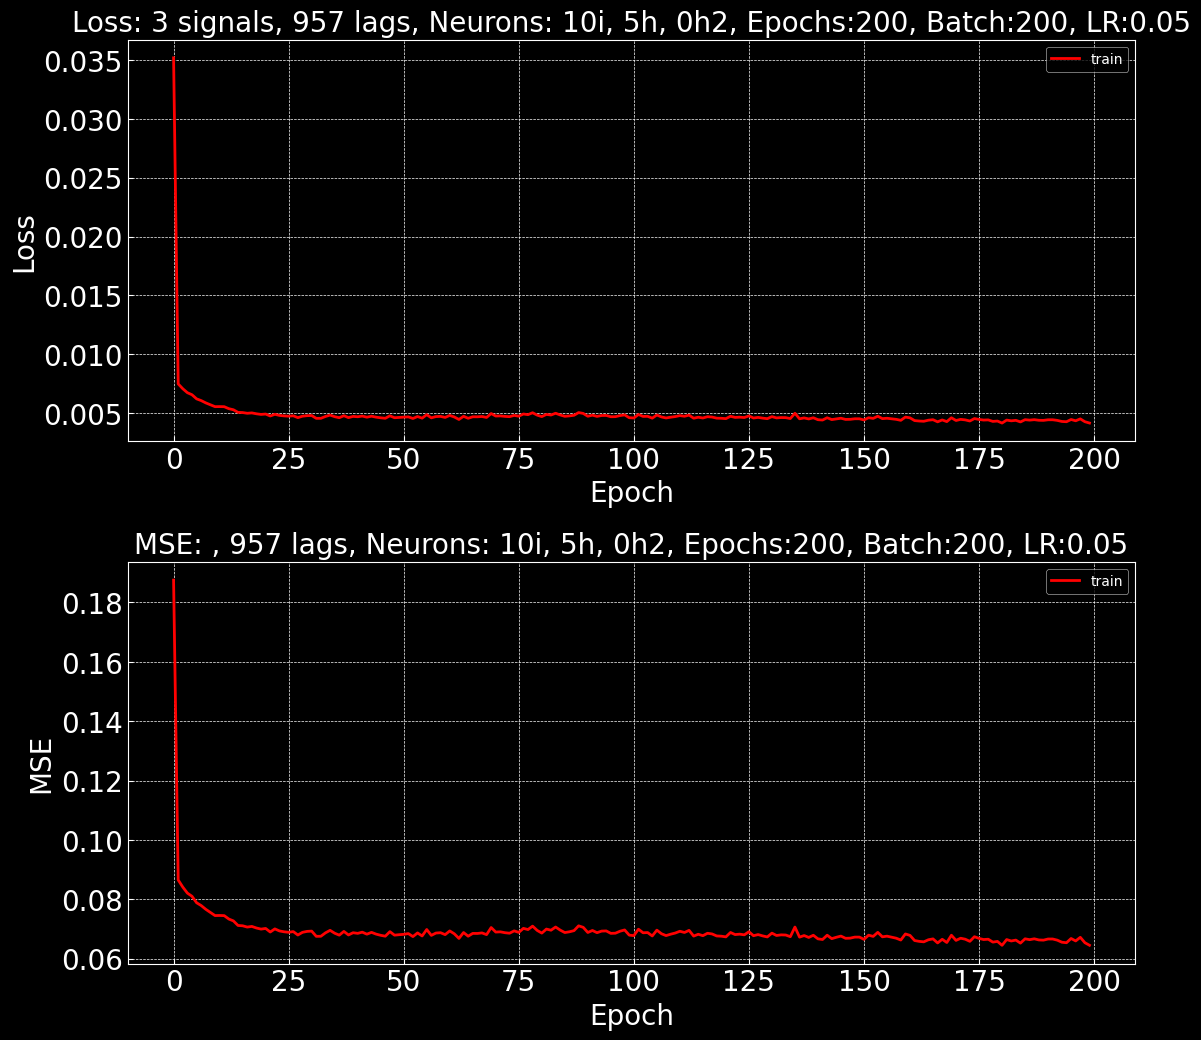

In [77]:
import tensorflow_addons as tfa
import tqdm

tqdm_callback = tfa.callbacks.TQDMProgressBar()
# def train(X, Y, tdnn_params, TDNN_model):
    
TDNN_model_hist = TDNN_model.fit(x_train, y_train, 
                                 epochs=tdnn_params['epochs'], 
                                 batch_size=tdnn_params['batch_size'],
                                 callbacks=[tqdm_callback],
                                 verbose=0)
plt.style.use('dark_background')
fig, axs = plt.subplots(2, 1, figsize=(13,12))
fig.subplots_adjust(hspace=0.3)
axs[0].set_title(f"Loss: 3 signals, {n_lag} lags, Neurons: {tdnn_net_arch['nn_i']}i, {tdnn_net_arch['nn_h1']}h, {tdnn_net_arch['nn_h2']}h2, Epochs:{tdnn_params['epochs']}, Batch:{tdnn_params['batch_size']}, LR:{tdnn_params['learning_rate']}", fontsize=20)
axs[0].plot(TDNN_model_hist.history['loss'], 'r', label='train')
# ax.plot(m_hist.history['val_loss'], 'b' ,label='val')
axs[0].set_xlabel(r'Epoch', fontsize=20)
axs[0].set_ylabel(r'Loss', fontsize=20)
axs[0].grid(True)
axs[0].legend()
axs[0].tick_params(labelsize=20)

# fig, axs = plt.subplots(2, 2, figsize=(10,6))
# ax.plot(np.sqrt(m_hist.history['mean_squared_error']), 'r', label='train')
# ax.plot(np.sqrt(m_hist.history['val_mean_squared_error']), 'b' ,label='val')
axs[1].set_title(f"MSE: , {n_lag} lags, Neurons: {tdnn_net_arch['nn_i']}i, {tdnn_net_arch['nn_h1']}h, {tdnn_net_arch['nn_h2']}h2, Epochs:{tdnn_params['epochs']}, Batch:{tdnn_params['batch_size']}, LR:{tdnn_params['learning_rate']}", fontsize=20)
axs[1].plot(np.sqrt(TDNN_model_hist.history['mse']), 'r', label='train')
# ax.plot(np.sqrt(m_hist.history['val_mse']), 'b' ,label='val')
axs[1].set_xlabel(r'Epoch', fontsize=20)
axs[1].set_ylabel(r'MSE', fontsize=20)
axs[1].grid(True)
axs[1].legend()
axs[1].tick_params(labelsize=20)
fig.savefig(f"../figures/Loss_MSE_lm1_s3{n_lag}lags.png")
    
    # return TDNN_model_hist

# TDNN_model_hist = train(x_train, y_train, tdnn_params, TDNN_model)

In [ ]:
!pip show pydot pydotplus graphviz

## 4.3. Model persistence

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(TDNN_model, to_file='../figures/TDNN_model.png', show_shapes = True)

def model_export():
    
    
    
    
    return None

### Save weights to HDF5

In [ ]:
from keras.models import model_from_json

TDNN_model.save_weights(f"../models/TDNN_model_weights.h5")
TDNN_model.save(f"../Models/TDNN_model.h5")
TDNN_model

In [ ]:
#%% Retrieve the model: load json and create model
with open('../Models/TDNN_model.h5', 'r') as json_file:    
    saved_model = json_file.read()

#saved_model_ = model_from_json(saved_model)
# load weights into new model:
# model_.load_weights("../Figures/TDNN_model.h5")
# print("Model loaded")


### Prediction

743/743 [==============================] - 1s 886us/step


Text(0.5, 1.0, 'Original Signal')

Text(0.5, 0, 'Samples')

Text(0, 0.5, 'Amplitude')

Text(0.5, 1.0, 'Y_hat: 3 signals')

Text(0.5, 0, 'Samples')

Text(0, 0.5, 'Amplitude')

Text(0.5, 0.98, 'TDNN_pred_signal 957lags Neurons:10i_5h1_0h2 Params: 200e_200bs_0.05lr')

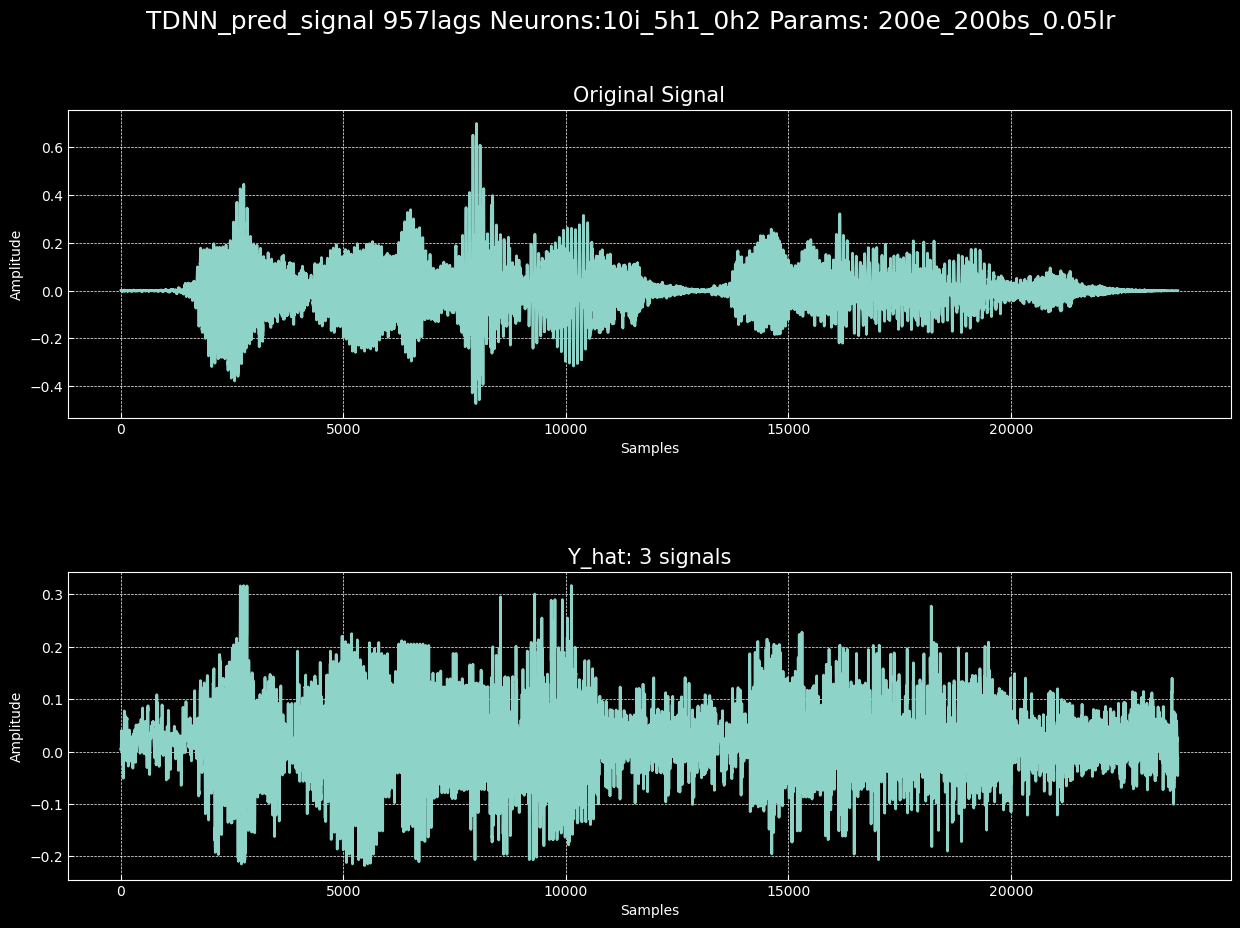

'../data/TDNN_pred_signal 957lags Neurons:10i_5h1_0h2 Params: 200e_200bs_0.05lr.wav'

In [78]:
def predict(data):
    
    y_pred = TDNN_model.predict(data)
    
    return y_pred

y_pred = predict(lm1)

path = '../data/'
file_name = f"TDNN_pred_signal {n_lag}lags Neurons:{tdnn_net_arch['nn_i']}i_{tdnn_net_arch['nn_h1']}h1_{tdnn_net_arch['nn_h2']}h2 Params: { tdnn_params['epochs'] }e_{ tdnn_params['batch_size'] }bs_{ tdnn_params['learning_rate']}lr"
format_wav = '.wav'
format_png = '.png'
s = path + file_name + format_wav

# Plotting original signal:
fig, axs = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(hspace=0.5)
#plt.tight_layout(pad=0.5)
axs[0].set_title(f'Original Signal', fontsize=15)
axs[0].plot(yv1)
axs[0].set_xlabel('Samples', fontsize=10)
axs[0].set_ylabel('Amplitude', fontsize=10)
axs[0].grid(True)

# Plotting predicted signal (y hat):
# fig = plt.figure(figsize=(20,10))
axs[1].set_title(f"Y_hat: 3 signals", fontsize=15)
axs[1].plot(y_pred)
axs[1].set_xlabel('Samples', fontsize=10)
axs[1].set_ylabel('Amplitude', fontsize=10)
axs[1].grid(True)
plt.suptitle(f"{file_name}", size=18)
plt.show()
fig.savefig(f'../figures/lm3_{file_name}_{n_lag}lags_p3.png', dpi=450 )

# Save to sound file:
# sf.write('../Data/X_train.wav', X_train_tdnn, ir_16k_sr, subtype=None)
# sf.write('../Data/Y_train.wav', Y_train_tdnn, ir_16k_sr, subtype=None)
# sf.write(s, y_pred, ir_16k_sr, subtype=None)
s

## 4. Performance Evaluation:

In [79]:
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, make_scorer)

Y_train_tdnn = yv1
tdnn_metrics = {
    'R2_score': r2_score(Y_train_tdnn, y_pred),
    'MSE': (mean_squared_error(Y_train_tdnn, y_pred)**0.5),
    'MAE': mean_absolute_error(Y_train_tdnn, y_pred),
    'MAPE': mean_absolute_percentage_error(Y_train_tdnn, y_pred)
}
tdnn_metrics

{'R2_score': 0.4277878080122298,
 'MSE': 0.06669571012465451,
 'MAE': 0.04769648620226104,
 'MAPE': 69.63666799402039}

Text(0.5, 0, 'Real output')

Text(0, 0.5, 'Estimation output')

Text(0.5, 0.98, 'R^2=0.4278')

Text(0.5, 1.0, 'lm3')

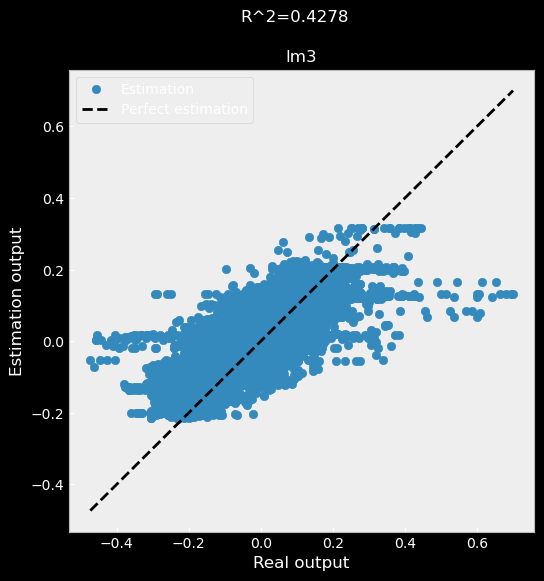

In [80]:

plt.style.use('bmh')
x_min,x_max = min(y_train),max(y_train)
xline = np.linspace(x_min,x_max)
fig = plt.figure(figsize=(6,6))
plt.scatter(yv1, y_pred,label='Estimation')
plt.plot(xline,xline,'k--',label='Perfect estimation')
plt.xlabel('Real output', fontsize=12)
plt.ylabel('Estimation output', fontsize=12)
plt.suptitle('R^2=%0.4f'%tdnn_metrics['R2_score'], fontsize=12)
plt.title(f"lm3", fontsize=12)
plt.legend()
plt.grid()
plt.show()
fig.savefig(f'../figures/R2_lm1_{n_lag}lags_p3.png', dpi=450)


## 4. Testing another Signal:
***

In [ ]:

#%%  Test

# Queen_y_pred = model.predict(ts_samples)
# sf.write('../Data/queen_predicted_signal.wav',Queen_y_pred, ts_sampling_rate, subtype=None)
# plt.show()
# plt.figure()
# plt.title('Queen Predicted Signal')
# plt.plot(Queen_y_pred,c='r')

# score = model.evaluate(matrix, samples[3:])
# print('Test loss:', score[0])
# print('Test mse:', score[1])

# corr = sig.correlate(y_pred, y_pred)

# plt.figure()
# plt.title('Signals Correlation')
# plt.plot(corr)
# plt.show()

#%% Hyperparameter tunning
from sklearn.model_selection import GridSearchCV

# RandomSearchCV


## Experimento: Recuperar señales con los pesos de la mejor señal obtenida: 

In [57]:

x3_2 = np.convolve(y3, ir_16k_samples, mode='same')

/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/numpy/core/numeric.py:843: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a, v = array(a, copy=False, ndmin=1), array(v, copy=False, ndmin=1)


ValueError: operands could not be broadcast together with shapes (19511,) (18945,) 

## Experiment: Comparing three individual signals vs the three signlas concatenated into an individual audio file:

In [53]:
y3.astype(np.int16).tofile(f'{PATH_TRAIN}three_signals.wav')
sf.write(f'{PATH_TRAIN}three_signal.wav',y3, sr, subtype=None)

/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/soundfile.py:335: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.asarray(data)


ValueError: dtype must be one of ['float32', 'float64', 'int16', 'int32'] and not 'object'

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.title('Convolved signal (Impulse Response * Original Speech Signal)',fontsize=20)
plt.grid()
lb.display.waveshow(y=conv_signal,sr=sr)
plt.show()
fig.savefig(f'../figures/Convolved_signal')
conv_signal.astype(np.int16).tofile(f'{PATH_TRAIN}conv_signal.wav')


## 4.3. XGBoost Model <a id='xgb'></a>
***

In [ ]:
!pip show xgboost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [ ]:
xgb_model = xgb.XGBRegressor()
xgb_model

### Parameter Definition:

In [ ]:
param_grid = {
    'n_estimators': range(100, 160, 20), # De 50 hasta 250 estimadores en aumentos de 50
    'learning_rate': [0.05], # Eta
    'max_depth': range(2, 4, 1),
    'subsample': [0.2, 0.5] # Submuestreo aleatorio para prevenir overfitting
}

In [ ]:
grid_search = GridSearchCV(estimator=xgb_model, 
                  param_grid=param_grid,
                  #scoring='neg_mean_squared_error',
                  scoring='r2',
                  n_jobs=1, # All proceiisors
                  cv=5,
                  verbose=2)

grid_search.fit(X_train_tdnn, Y_train_tdnn)
print("Mejores parámetros:",grid_search.best_params_)

In [ ]:
best_params = {
    'n_estimators': 110, # De 50 hasta 250 estimadores en aumentos de 50
    'learning_rate': 0.05, # Eta
    'max_depth': 2,
    'subsample': 0.2
    }
xgb_best_model = xgb.XGBRegressor(
                             n_estimators = best_params['n_estimators'],
                             max_depth = best_params['max_depth'],
                             eval_metric = 'r2',
                             learning_rate = best_params['learning_rate'],
                             verbosity = 4,
                             n_jobs = -1,
                             gamma = 1,)

In [ ]:
xgb_best_model = grid_search.best_estimator_
xgb_best_model

#### Save model for model persistence:

In [ ]:
import pickle

xgb_best_model.save_model("../Models/xgb_best_model.json")
pickle.dump(xgb_best_model, open("../Models/xgb_best_model.pkl", "wb"))

In [ ]:
def load_pkl(fname):
    with open(fname, 'rb') as f:
        obj = pickle.load(f)
    return obj

xgb_best_model = load_pkl('../Models/xgb_best_model.pkl')
xgb_best_model

### Realizar predicción sobre la señal original:

In [ ]:
xgb_best_Yhat = xgb_best_model.predict(X_train_tdnn)
xgb_best_Yhat.shape

### Calcular scores de la predicción del modelo:

In [ ]:
xgb_best_rmse = (mean_squared_error(Y_train_tdnn, xgb_best_Yhat)**0.5)
xgb_best_mae = mean_absolute_error(Y_train_tdnn, xgb_best_Yhat)
xgb_best_mape = mean_absolute_percentage_error(Y_train_tdnn, xgb_best_Yhat)
xgb_best_r2 = r2_score(Y_train_tdnn, xgb_best_Yhat)
print('RMSE: {0:.3f}'.format(xgb_best_rmse))
print('MAE: {0:.3f}'.format(xgb_best_mae))
print('MAPE: {0:.3f}'.format(xgb_best_mape))
print('R^2: {0:.3f}'.format(xgb_best_r2))

In [ ]:

# Plotting original signal:
fig, axs = plt.subplots(2, 1, figsize=(12,10))
fig.subplots_adjust(hspace=0.2)
# plt.tight_layout(pad=0.7)
axs[0].set_title(f'Original Signal', fontsize=10)
axs[0].plot(Y_train_tdnn)
axs[0].set_xlabel('Samples', fontsize=10)
axs[0].set_ylabel('Amplitude', fontsize=10)
axs[0].grid(True)

# Plotting predicted signal (y hat):
# fig = plt.figure(figsize=(20,10))
axs[1].set_title(f'XGBoost Predicted Signal: {n_lag} lags, Estimators: {xgb_best_model.n_estimators}, Max depth: {xgb_best_model.max_depth}, Learning rate: {xgb_best_model.learning_rate}', fontsize=10)
axs[1].plot(xgb_best_Yhat)
axs[1].set_xlabel('Samples', fontsize=10)
axs[1].set_ylabel('Amplitude', fontsize=10)
axs[1].grid(True)
plt.show()
fig.savefig(f'../Figures/xgb_yhat_{n_lag}lags_{xgb_best_model.n_estimators}estimators_{xgb_best_model.max_depth}mdepth_{xgb_best_model.learning_rate}lr.png', dpi=450 )


In [ ]:
# Save to sound file:
sf.write(f'../Data/XGB_pred_signal_{n_lag}lags_{xgb_best_model.n_estimators}estimators_{xgb_best_model.max_depth}mdepth_{xgb_best_model.learning_rate}lr.wav',xgb_best_Yhat, sr, subtype=None)


In [ ]:
# Graph and save the predicted signal:


#%% Save a model to JSON

# serialize model to JSON
model_json = model.to_json()

with open("../Figures/TDNN_model.json", "w") as json_file:
    json_file.write(model_json)


## 7. Conclusiones <a id='conclusiones'></a>
***

[Top](#top)

# 8. Referencias <a id='ref'></a>
***
[]

[]

[]

